# <b><h1>Disco Data Processing Script</h1>
<h2>Part 1 Reading and Cleaning Data</h2></b>

Prior to running the script, please ensure you have inserted all the books you would like to be analyzed inside the input directory. The code will create custom output folders based on the name of the input books, so nothing overwrites.
    
<b>Your Folder Should Look Like:</b>    
- disco-data-processing.py
- disco-data-processing.ipynb
- input/"raw_book_with_a_short_title_you_like.xlsx" (i.e. "PAA.xlsx")

<h2>Part 2 Statistical Analysis</h2>

<p>Use the exploratory data visualizations from part 1 to see if you're on the right track, and to give context to the statistical analysis.</p>


In [1]:
# importing required libraries:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
from scipy.stats import t
import scipy.stats as stats
from scipy.optimize import curve_fit
import os 
import glob

# define handy shortcut for indexing a multi-index dataframe
idx = pd.IndexSlice

Make sure to run all of the function definition cells below first if you are in Jupyter Notebook.

In [2]:
def convert_excel_to_dataframe(b):
    '''
    This function converts raw Excel books containing outputs from DISCO-NMR experiments into cleaned and 
    organized Pandas DataFrames for further processing.
    
    Inputs are:
    b = The file path to the excel book of interest, obtained generalizably from the "list_of_raw_books" defined above
    
    Output is a tuple (clean_tuple) in a "key-value pair format,"" where the key (at index 0 of the tuple) is:
        current_book_title, a string containing the title of the current excel input book
   
    And the value (at index 1 of the tuple) is:
        clean_df, the cleaned pandas dataframe corresponding to that book title!

    '''
    # PREPARE AND INITIALIZE REQUIRED VARIABLES FOR DATA WRANGLING --------------
    
    # grab the current book title, and drop the file extension from current book title for easier file naming in the rest of the code
    current_book_title = os.path.basename(str(b))
    sep = '.'
    current_book_title = current_book_title.split(sep, 1)[0]
    
    print("The current book being analyzed is: ", current_book_title)

    # determine the number of sheets, samples, & controls in the workbook
    name_sheets = pd.ExcelFile(b).sheet_names
    num_sheets = (len(pd.ExcelFile(b).sheet_names))
    
    # initialize number of samples and controls to zero, then initialize the "list initializers" which will hold book-level data to eventually add to the book-level dataframe.
    num_samples = 0
    num_controls = 0
    sample_control_initializer = []
    sample_replicate_initializer = []
    control_replicate_initializer = []
    
    # initialize a list to contain the mini experimental dataframes collected from within the current book, which will be concatenated at the end to create one dataframe "organized_df" that represents this book
    df_list = []
    
    # BEGIN WRANGLING DATA FROM THE EXCEL FILE, AND TRANSLATING INTO ORGANIZED DATAFRAME ----------------

    # loop through sheet names to determine number of samples and controls in this book
    for s in range(len(name_sheets)):
        
        # if the current sheet is labeled Sample: 
        # increment sample counter, add a list item called 'sample' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.
        if ('Sample' or 'sample') in name_sheets[s]:
            num_samples += 1
            sample_control_initializer.append('sample')
            sample_replicate_initializer.append(num_samples)
            
        # if the current sheet is labeled Control: 
        # increment control counter, add a list item called 'control' to be initialized into the 'sample_or_control' list, add a list item of the replicate number to be initialized into the 'replicate' list.   
        elif ('Control' or 'control') in name_sheets[s]:
            num_controls += 1
            sample_control_initializer.append('control')
            control_replicate_initializer.append(num_controls)
    
    print("There are", num_sheets, "sheets identified in the current book.")
    print("Number of samples sheets identified:", num_samples)
    print("Number of control sheets identified:", num_controls)
    
    if num_samples != num_controls:
        print('\nERROR: The number of sample sheets is not equal to the number of control sheets in', b, 'please confirm the data in the book is correct.')
    
    # combine sample and control initializers to create the total replicate index list
    total_replicate_index = sample_replicate_initializer + control_replicate_initializer
    print("Sample and control data initialization complete at the book-level. Beginning experiment-specific data acquisition.\n")
    
    #FOR TESTING, can set num_sheets = 1
#     num_sheets = 1
    
    # loop through each sheet in the workbook
    for n in range(num_sheets):

        # read in the current book's nth sheet into a Pandas dataframe
        current_sheet_raw = pd.read_excel(b, sheet_name=n)
        print("Reading Book Sheet:", n)
        
        # if the name of the sheet is not a sample or control, skip this sheet and continue to the next one 
        if (any(['ample' not in name_sheets[n]]) & any(['ontrol' not in name_sheets[n]])):
            print("Skipping sheet", n, "as not a sample or control.")
            continue

        # drop first always empty unnamed col (NOTE - consider building error handling into this to check the col is empty first)
        to_drop = ['Unnamed: 0']
        current_sheet_raw.drop(columns = to_drop, inplace = True)

        # loop through columns and "fill right" to replace all Unnamed columns with their corresponding title_string value
        for c in current_sheet_raw.columns:
            current_sheet_raw.columns = [current_sheet_raw.columns[i-1] if 'Unnamed' in current_sheet_raw.columns[i] else current_sheet_raw.columns[i] for i in range(len(current_sheet_raw.columns))]

        # identifies the coordinates of the left-most parameter in each experimental set, conc (um)
        i, c = np.where(current_sheet_raw == 'conc (um)')

        # assigns coordinates of all upper left 'conc (um) cells to an index (row) array and a column array
        conc_indices = current_sheet_raw.index.values[i]
        conc_columns = current_sheet_raw.columns.values[c]

        # determine the number of experimental rows in each NMR results sub-table
        # subtract one to exclude conc cell row itself
        num_experimental_indices = np.unique(conc_indices)[2] - np.unique(conc_indices)[1] - 1

        # determine the number of experimental columns in each NMR results sub-table
        (unique_exp_cols, count_experimental_cols) = np.unique(conc_columns, return_counts = True)
        num_experimental_cols = np.unique(count_experimental_cols)[0]

        # initialize/reset dfs, current is for CURRENT sub-tables being looped over, organized_df is to concatenate all the sub-dfs in this book
        current_exp_df = []
        organized_df = []
        
        # make a list of coordinate pair tuples for this sheet using list comprehension
        sheet_coords_list = [(conc_indices[i], conc_columns[i]) for i in range(len(conc_indices))]

        for coords in sheet_coords_list:
        
            # Determine the current 'sample_or_control' and 'replicate' values by taking the nth value (aka current sheet value) from the lists determined above
            current_sample_or_control = sample_control_initializer[n]
            current_replicate = total_replicate_index[n]

            # assign current values to the fixed experimental parameters for this experimental sub-table
            fixed_parameters_per_set = current_sheet_raw.loc[coords[0], coords[1]]
    
            # Hard coding the indices of the different parameters based on constant pattern in input file 
            current_title_string = fixed_parameters_per_set.index[0]
            current_concentration = fixed_parameters_per_set[1]
            current_sat_time = fixed_parameters_per_set[3]
            current_irrad_bool = fixed_parameters_per_set[5]

            # initialize/reset experimental lists to null for this experimental set
            list_current_ppm_experimental = []
            list_current_intensity_experimental = []
            list_current_width_experimental = []
            list_current_area_experimental = []
            list_current_type_experimental = []
            list_current_flags_experimental = []
            list_current_impuritycomp_experimental = []
            list_current_annotation_experimental = []
            list_current_range_experimental = []
            list_current_normalized_experimental = []
            list_current_absolute_experimental = []

            # now need to find and assign the sub-table's actual experimental data to the new lists 
                
            # Initializing the "boundaries" of the sub-table rectangle containing values of interest in a generalizable way, based on conc as the upper left value
            experimental_index_starter = coords[0]+1
            experimental_index_range = range(num_experimental_indices)
            experimental_column_range = range(num_experimental_cols)
            combined_experimental_index_range = experimental_index_starter + experimental_index_range

            # Obtain experimental column range using boolean mask as column labels are title_strings for each experimental set
            experimental_column_range_mask = current_sheet_raw.columns.get_loc(coords[1])
            combined_experimental_column_range = np.where(experimental_column_range_mask)
            
            # loop through and collect experimental index and experimental column range for the ith and jth experimental sub-table
            for ei in combined_experimental_index_range:
                for ec in combined_experimental_column_range:
                    
                    # use iloc to grab NMR experimental variables for this set into a series
                    variable_parameters_per_set = current_sheet_raw.iloc[ei, ec]

                    # append designated variable parameters into lists for those parameters in the current experimental sub-set
                    # this is hard coded based on known order of columns in the input file structure that should theoretically be consistent...
                    list_current_ppm_experimental.append(variable_parameters_per_set.iloc[1])
                    list_current_intensity_experimental.append(variable_parameters_per_set.iloc[2])
                    list_current_width_experimental.append(variable_parameters_per_set.iloc[3])
                    list_current_area_experimental.append(variable_parameters_per_set.iloc[4])
                    list_current_type_experimental.append(variable_parameters_per_set.iloc[5])
                    list_current_flags_experimental.append(variable_parameters_per_set.iloc[6])
                    list_current_impuritycomp_experimental.append(variable_parameters_per_set.iloc[7])
                    list_current_annotation_experimental.append(variable_parameters_per_set.iloc[8])
                    list_current_range_experimental.append(variable_parameters_per_set.iloc[11])
                    list_current_normalized_experimental.append(variable_parameters_per_set.iloc[12])
                    list_current_absolute_experimental.append(variable_parameters_per_set.iloc[13])
                    

            # after all the experimental lists are populated, define length of the experimental parameter lists (number of true experimental rows)
            exp_list_length = len(list_current_ppm_experimental)

            # create "ranged" lists of the constant experimental values to make them the same length as the unique variable experimental values, so we can add information "per observation" to the dataframe
            ranged_sample_or_control = exp_list_length * [current_sample_or_control]
            ranged_replicate = exp_list_length * [current_replicate]
            ranged_title_string = exp_list_length * [current_title_string]
            ranged_concentration = exp_list_length * [current_concentration] 
            ranged_sat_time = exp_list_length * [current_sat_time]
            ranged_irrad_bool = exp_list_length * [current_irrad_bool]
                
            # assign all current experimental values for this experimental set to a dataframe via a dictionary
            current_dict = {"sample_or_control":ranged_sample_or_control,
                                "replicate":ranged_replicate,
                                "title_string":ranged_title_string, 
                                "concentration":ranged_concentration,
                                "sat_time":ranged_sat_time, 
                                "irrad_bool":ranged_irrad_bool, 
                                "ppm":list_current_ppm_experimental, 
                                "intensity":list_current_intensity_experimental, 
                                "width":list_current_width_experimental, 
                                "area":list_current_area_experimental, 
                                "type":list_current_type_experimental, 
                                "flags":list_current_flags_experimental, 
                                "impurity_compound":list_current_impuritycomp_experimental, 
                                "annotation":list_current_annotation_experimental, 
                                "range":list_current_range_experimental, 
                                "normalized":list_current_normalized_experimental, 
                                "absolute":list_current_absolute_experimental}
            
            current_exp_df = pd.DataFrame(current_dict)
    
            # before moving on to next experimental set, append the dataframe from this experimental set to a book-level list of dataframes
            df_list.append(current_exp_df)

        print("Data frame for the experimental set at coordinates:", coords, "has been appended to the book-level list of dataframes.\n")
    
    # concatenate the mini dataframes appended to the df_list into one big organized dataframe for this book!
    organized_df = pd.concat(df_list)
    print("The input book {} has been wrangled into an organized dataframe! Now initializing dataframe cleaning steps.\n".format(current_book_title))
    
    # BEGIN CLEANING THE ORGANIZED DATAFRAME ----------------------------------------------------
    
    # Need to remove redundant rows (generated by the data processing loops above)

    # assign prosepctive redundant title rows at index zero to a variable
    organized_df_redundant = organized_df[organized_df.index == 0]

    # to make sure the standard expected redundant rows are actually redundant (expected redundant row is a duplicate of the column labels)
    # check that there is only one unique 'absolute' value (duplicate rows will only have one unique value, as they are titles)
    if organized_df_redundant.nunique().loc['absolute'] == 1:
        clean_df = organized_df[organized_df.index != 0]
    else: 
        print("Warning, assumed redundant rows for further processing are not actually redundant. Proceeding.\n")
        clean_df = organized_df
    
    # remove any duplicate rows
    clean_df = clean_df.drop_duplicates()

    # export the cleaned dataframe of the book to excel in a custom output folder
    output_directory = "output_from_{}".format(current_book_title)
    output_file_name = "{}_clean_raw_dataframe.xlsx".format(current_book_title)

    # make directory if there isn't already one for output 
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    print('Dataframe cleaning complete!\n')
    print('Now exporting the cleaned dataframe in Excel format to a custom output directory for reference.\n')
    clean_df.to_excel(os.path.join(output_directory, output_file_name))

    print('Excel export complete! Navigate to output directory to see the clean Excel file.\n')
    
    # merge current_book_title and clean_df into a tuple, as "key value pairs" that can be generically indexed
    clean_tuple = (current_book_title, clean_df)
    print('Function has returned a tuple containing the title of the current book, and the cleaned dataframe for {}.\n'.format(current_book_title))
    
    return clean_tuple


In [3]:
def attenuation_calc_equality_checker(compare_df_1, compare_df_2):
    
    '''This functions checks to see if two subset dataframes for the attenuation calculation, one where irrad bool is true, one where irrad bool is false, for calculating attenuation
    are equal and in the same order in terms of their fixed experimental parameters. 'sample_or_control', 'replicate', 'title_string', 'concentration', 
    'sat_time' '''
    
    if (compare_df_1.shape == compare_df_2.shape):
        
        subset_compare_1 = compare_df_1[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time']]
        subset_compare_2 = compare_df_2[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time']]
        exactly_equal = subset_compare_2.equals(subset_compare_1)
    
        return exactly_equal
        
    else:
        return print("Error, irrad_false and irrad_true dataframes are not the same shape to begin with.")

def corrected_attenuation_calc_equality_checker(compare_df_1, compare_df_2, compare_df_3):  
    
    '''This functions checks to see if the three subset dataframes for calculating the corrected % attenuation
    are equal and in the same order in terms of their shared fixed experimental parameters. 'replicate', 'concentration', 
    'sat_time' '''
    
    #check if number of rows same in each df, number of columns not same as samples dfs contain attenuation data
    if (compare_df_1.shape[0] == compare_df_2.shape[0] == compare_df_3.shape[0]):
        
        subset_compare_1 = compare_df_1[['replicate', 'concentration', 'sat_time']]
        subset_compare_2 = compare_df_2[['replicate', 'concentration', 'sat_time']]
        subset_compare_3 = compare_df_3[['replicate', 'concentration', 'sat_time']]
        exactly_equal_1 = subset_compare_2.equals(subset_compare_1)
        
        if exactly_equal_1 == True:
            exactly_equal_2 = subset_compare_3.equals(subset_compare_2)
            return exactly_equal_2
        
        else: return exactly_equal_1
        
    else:
        return print("Error, corrected % attenuation input dataframes are not the same shape to begin with.")

In [4]:
def add_attenuation_and_corr_attenuation_to_dataframe(current_book):
    '''
    This function calculates the attenuation, and corr_%_attenuation if the dataframe passes all checks
    (based on the order of items) by means of simple arithmetic operations.
    
    Input: current_book, the dataframe output from the convert_excel_to_dataframe() function.
    
    Outut: corr_p_attenuation_df, an updated dataframe that includes the attenuation and corr_%_attenuation columns.
    
    '''
    
    # to get get % attenuation of peak integral, define true and false irrad dataframes below, can perform simple subtraction if passes check
    intensity_irrad_true = current_book.loc[(current_book['irrad_bool'] == 1.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]
    intensity_irrad_false = current_book.loc[(current_book['irrad_bool'] == 0.0), ['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute']]

    # check if the fixed experimental values in irrad true and irrad false are equal, in the same order, and the same size, so that one to one calculations can be performed to calculate attenuation.
    fixed_values_equality_check = attenuation_calc_equality_checker(intensity_irrad_true, intensity_irrad_false)

    # if the test passes, calculate attenuation and append to dataframe
    if fixed_values_equality_check == True:
        p_attenuation_intensity = intensity_irrad_false[['absolute']] - intensity_irrad_true[['absolute']]

        #Update irradiated dataframe to include the % attenuation of the irradiated samples and controls
        intensity_irrad_true['attenuation'] = p_attenuation_intensity
        print("Test 1 passed, attenuation has been calculated and appended to dataframe.")
        
    else:
        print("Error, intensity_irrad true and false dataframes are not equal, cannot compute signal attenutation in a one-to-one manner.")

    # Now check we are good to calculate the corrected % attenuation, and then calculate: ------------------------

    #subset the dataframe where irrad is true for samples only
    p_atten_intensity_sample = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]
    #subset the dataframe where irrad is true for controls only
    p_atten_intensity_control = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'control')]
    #subset dataframe where irrad is false for samples only
    intensity_irrad_false_sample = intensity_irrad_false.loc[(intensity_irrad_false['sample_or_control'] == 'sample')]

    #check if the fixed experimental values in irrad true and irrad false are equal, in the same order, and the same size, so that one to one calculations can be performed to calculate attenuation.
    corr_atten_equality_check = corrected_attenuation_calc_equality_checker(p_atten_intensity_sample, p_atten_intensity_control, intensity_irrad_false_sample)    

    if corr_atten_equality_check == True:

        #Grab Attenuation data for subset with samples only where irrad is true  
        p_atten_intensity_sample_data = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'sample')]['attenuation']
        #Grab Attenuation data for subset with controls only where irrad is true
        p_atten_intensity_control_data = intensity_irrad_true.loc[(intensity_irrad_true['sample_or_control'] == 'control')]['attenuation']
        #Grab Absolute peak integral data for subset with samples only where irrad is false to normalize attenuation
        intensity_irrad_false_sample_data = intensity_irrad_false.loc[(intensity_irrad_false['sample_or_control'] == 'sample')]['absolute']

        #initialize dataframe to store corrected p_attenuation with the shared fixed parameters and sample identifier parameters
        corr_p_attenuation_df = pd.DataFrame(p_atten_intensity_sample[['sample_or_control', 'replicate', 'title_string', 'concentration', 'sat_time', 'ppm', 'intensity', 'range', 'normalized', 'absolute', 'attenuation']])

        #Calculate Corrected % Attentuation, as applies to
        corr_p_attenuation_df['corr_%_attenuation'] = ((1/intensity_irrad_false_sample_data)*(p_atten_intensity_sample_data - p_atten_intensity_control_data))
        print("Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.")
        
        return corr_p_attenuation_df

    else:
        return print("Error, input dataframes are not equal, cannot compute corrected signal attenutation in a one-to-one manner.")
        

In [5]:
def generate_concentration_plot(current_df_attenuation):
    
    '''
    This function generates a basic exploratory stripplot of polymer sample attenuation vs saturation time using
    concentration is a "hue" to differentiate points. 
    
    This function also saves the plot to a custom output folder.
    
    Input: dataframe after attenuation and corrected % attenuation have been calculated.
    Output: saves plot to file, and displays it.
    
    '''
    a4_dims = (11.7, 8.27)
    fig1, ax = pyplot.subplots(figsize = a4_dims)
    sns.stripplot(ax = ax, x = 'sat_time', y = 'corr_%_attenuation', data = current_df_attenuation, hue = 'concentration', palette = 'viridis')

    plt.title("Polymer Sample Attenuation vs Saturation Time")
    plt.ylabel("Corrected Signal Intensity Attenuation (%)")
    plt.xlabel("NMR Pulse Saturation Time (s)")
    
        
    # define file name for the concentration plot
    output_file_name_conc = "{}/exploratory_concentration_plot_from_{}.png".format(output_directory_exploratory, current_df_title)
    
    # export to file
    fig1.savefig(output_file_name_conc, dpi=300)

    return

In [6]:
def generate_ppm_plot(current_df_attenuation):
    
    '''
    This function generates a basic exploratory scatterplot of polymer sample attenuation vs saturation time using
    ppm as a "hue" to differentiate points. 
    
    This function also saves the plot to a custom output folder.
    
    Input: dataframe after attenuation and corrected % attenuation have been calculated.
    Output: saves plot to file, and displays it.
    '''
    
    a4_dims = (11.7, 8.27)
    fig2, ax2 = pyplot.subplots(figsize = a4_dims)
    sns.scatterplot(ax = ax2, x = 'sat_time', y = 'corr_%_attenuation', data = current_df_attenuation, hue ='ppm', palette = 'viridis', y_jitter = True, legend = 'brief')

    # a stripplot looks nicer than this, but its legend is unneccessarily long with each individual ppm, need to use rounded ppm to use the below line
    # sns.stripplot(ax = ax2, x = 'sat_time', y = 'corr_%_attenuation', data = corr_p_attenuation_df, hue ='ppm', palette = 'viridis', dodge = True)

    plt.title("Polymer Sample Attenuation vs Saturation Time")
    plt.ylabel("Corrected Signal Intensity Attenuation  (%) by ppm")
    plt.xlabel("NMR Pulse Saturation Time (s)")
    ax2.legend() 
    
    # define file name for the concentration plot
    output_file_name_ppm = "{}/exploratory_ppm_plot_from_{}.png".format(output_directory_exploratory, current_df_title)
    
    # export to file
    fig2.savefig(output_file_name_ppm, dpi=300)
    
    
    return

In [7]:
def prep_mean_data_for_stats(corr_p_attenuation_df):
    
    '''
    This function prepares the dataframe for statistical analysis after the attenuation and corr_%_attenuation
    columns have been added.
    
    Statisical analysis is performed on a "mean" basis, across many experimental replicates.
    This code prepares the per-observation data accordingly, and outputs the mean_df_for_stats.
    
    It drops the columns and rows not required for stats, calculates the mean and std of parameters we do 
    care about, and also appends the degrees of freedom and sample size.
    
    Input: current_df_attenuation
    Output: mean_current_df_for_stats 
    
    '''
    
    # drop any rows that are entirely null from the dataframe 
    corr_p_attenuation_df = corr_p_attenuation_df.dropna(how = "any")
    
    # now drop the column fields that are not required for stats modelling and further analysis
    data_for_stats = corr_p_attenuation_df.drop(columns = ['title_string', 'sample_or_control', 'intensity', 'range', 'normalized', 'absolute', 'attenuation'])

    # Add a new column to data for the index of proton peaks in an experimental set of a polymer (i.e. proton peak index applies to index protons within one polymer book)
    proton_index = data_for_stats.index
    data_for_stats['proton_peak_index'] = proton_index
    
    #determine mean corr % attenuation and mean ppm per peak index, time, and concentration across replicates using groupby sum (reformat) and groupby mean (calculate mean)
    regrouped_df = data_for_stats.groupby(by = ['concentration', 'sat_time', 'proton_peak_index', 'replicate'])[['ppm','corr_%_attenuation']].sum()

    #generate a table that includes the mean and std for ppm and corr_%_atten across the replicates, reset index
    mean_corr_attenuation_ppm = regrouped_df.groupby(by = ['concentration', 'sat_time', 'proton_peak_index']).agg({'ppm': ['mean', 'std'], 'corr_%_attenuation': ['mean', 'std']})
    
    def get_dofs(peak_indices_array):
    
        ''' This function calculates the number of degrees of freedom (i.e. number of experimental replicates minus one) for statistical calculations 
        using the "indices array" of a given experimenal set as input.
    
        Input should be in the format: (in format: 11111 22222 3333 ... (specifically, it should be the proton_peak_index column from the "regrouped_df" above)
        where the count of each repeated digit minus one represents the degrees of freedom for that peak (i.e. the number of replicates -1).
        With zero based indexing, the function below generates the DOFs for the input array of proton_peak_index directly, in a format
        that can be directly appended to the stats table.
        '''

        dof_list = []
        dof_count = 0
        global_count = 0

        #loop through range of the peak indices array 
        for i in range(len(peak_indices_array)):
            global_count = global_count +1

            #if at the end of the global range, append final incremented dof count
            if global_count == len(peak_indices_array):
                dof_count = dof_count+1
                dof_list.append(dof_count)
                break

            #if current index is not equal to the value of the array at the next index, apply count of current index to DOF list, and reset DOF counter
            elif peak_indices_array[i] != peak_indices_array[i+1]:
                dof_list.append(dof_count)
                dof_count = 0

            #otherwise, increment DOF count and continue
            else:
                dof_count = dof_count + 1

        return dof_list
    
    #Calculate degrees of freedom and sample size for each datapoint using function above
    peak_index_array = np.array(regrouped_df.index.get_level_values(2))
    dofs = get_dofs(peak_index_array)

    #append a new column with the calculated degrees of freedom to the table for each proton peak index
    mean_corr_attenuation_ppm['dofs'] = dofs
    mean_corr_attenuation_ppm['sample_size'] = np.asarray(dofs) + 1
    
    
    return mean_corr_attenuation_ppm 

In [8]:
def prep_replicate_data_for_stats(corr_p_attenuation_df):
    
    '''
    This function prepares the dataframe for statistical analysis after the attenuation and corr_%_attenuation
    columns have been added.
    
    This code prepares the per-observation data accordingly, and outputs the replicate_df_for_stats.
    
    It drops the columns and rows not required for stats, and adds the proton peak index.
    
    Input: current_df_attenuation
    Output: replicate_current_df_for_stats 
    
    '''
    
    # drop any rows that are entirely null from the dataframe 
    corr_p_attenuation_df = corr_p_attenuation_df.dropna(how = "any")
    
    # now drop the column fields that are not required for stats modelling and further analysis
    replicate_df_for_stats = corr_p_attenuation_df.drop(columns = ['title_string', 'sample_or_control', 'intensity', 'range', 'normalized', 'absolute', 'attenuation'])

    # Add a new column to data for the index of proton peaks in an experimental set of a polymer (i.e. proton peak index applies to index protons within one polymer book)
    proton_index = replicate_df_for_stats.index
    replicate_df_for_stats['proton_peak_index'] = proton_index
    
    return replicate_df_for_stats

In [9]:
def get_t_test_results(mean_corr_attenuation_ppm):

    ''' 
        Procedure followed from: https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/ 

        One sample t test: tests whether the mean of a population is significantly different than a sample mean.
        A proper t-test analysis performs calculations to help infer what the expected population mean (that 
        contains the sample) given just a sample mean. (Inferential statistics).

        Null Hypothesis: population mean = sample mean (avg corr % attenuation for a proton peak of N replicates at fixed experimental parameters)
        Alternative Hypothesis: population mean >= sample mean (avg corr % attenuation for a proton peak of N replicates at fixed experimental parameters)

        Population parameters used are that of the student's t distribution.
        Alpha = 0.1 for statistical significance. 

        Still theoretically need to validate sample data meets assumptions for one sample t test: normal dist, homegeneity of variance, & no outliers. **
        
        Input: current_df_mean after having been prepared for stats (output from prep_mean_data_for_stats)
        Output: The same df as input, only now with the t test values and results appended
        
    '''

    # Initialize Relevant t test Parameters
    p = 0.90
    dof = mean_corr_attenuation_ppm['dofs']
    mean_t = mean_corr_attenuation_ppm['corr_%_attenuation']['mean'].abs()
    std_t = mean_corr_attenuation_ppm['corr_%_attenuation']['std']
    sample_size_t = mean_corr_attenuation_ppm['sample_size']

    # retrieve value <= probability from t distribution, based on DOF for sample 
    crit_t_value = t.ppf(p, dof)
    # print(crit_t_value)

    # confirm the p value with cdf, for sanity checking 
    # p = t.cdf(crit_t_value, dof)
    # print(p)

    #perform one sample t-test for significance, significant if t_test_results < 0 
    t_test_results =  mean_t - crit_t_value * (std_t/(np.sqrt(sample_size_t)))
    mean_corr_attenuation_ppm['t_results'] = t_test_results
    mean_corr_attenuation_ppm['significance'] = mean_corr_attenuation_ppm['t_results'] > 0

    #Return the dataframe with the new t test columns appended
    return mean_corr_attenuation_ppm

In [10]:
def compute_amplification_factor(current_mean_stats_df, current_replicate_stats_df, af_denominator):
    '''
    This function computes an amplification factor for the mean stats df and the replicate stats df.
    Each polymer may have a different denominator to consider for the amp factor calculation, so it
    is passed into this function as a variable.
    
    Input: mean_stats_df, replicates stats df, the denominator for amp factor calculation
    Output: mean_stats_df, replicates_stats_df with the amp factor column 
    
    For each concentration, compute the amplification factor AFconc = Cj/10. 
    
    '''
    # Note: We can adjust amp factor denominator as required based on experimental input for a given polymer. For PAA it is 10.
    amp_factor_denominator = af_denominator
    amp_factor = np.array(current_mean_stats_df.index.get_level_values(0))/amp_factor_denominator
    current_mean_stats_df['amp_factor'] = amp_factor

    # Calculate the amplification factor for the data_for_stats ungrouped table as well (i.e. per replicate data table)
    current_replicate_stats_df['amp_factor'] = np.array(current_replicate_stats_df[['concentration']])/amp_factor_denominator

    # return the mean data table with the amp_factor added
    return current_mean_stats_df, current_replicate_stats_df

In [11]:
def drop_bad_peaks(current_df_mean, current_df_replicates):

    '''
    This function identifies whether proton peaks pass or fail an acceptance criterion to allow
    them to be further analyzed. If the peaks fail, they are dropped from further analysis.
    
    Criterion for dropping peaks from Further consideration: If more than two proton peak datapoints are flagged as not significant in the mean dataframe 
    WITHIN a given concentration, the associated proton peak is removed from further analysis.
    
    Input: current_df_mean and current_df_replicats
    Outputs: the same dataframes, after dropping proton peaks that fail criterion, writes a text file of which points have been dropped

    '''

    #initialize a df that will keep data from the current mean df that meet the criterion above
    significant_corr_attenuation = current_df_mean

    #The below code checks data for the criterion and then removes rows if they do not pass for the mean df --------

    # Assign unique protons to a list to use for subsetting the df via multi-index and the multi-index slicing method
    unique_protons = current_df_replicates.proton_peak_index.unique()
    unique_concentrations = current_df_replicates.concentration.unique().tolist()

    #initialize list to contain the points to remove 
    pts_to_remove = []

    for p in unique_protons:
        for c in unique_concentrations:

            #subset the df via index slice based on the current peak and concentration
            current_subset_df = significant_corr_attenuation.loc[idx[c, :, p]]

            #subset further for where significance is false
            subset_insignificant = current_subset_df.loc[(current_subset_df['significance'] == False)]

            #if there's more than 2 datapoints where significance is False within the subset, drop p's proton peaks for c's concentration from the significant_corr_attenuation df
            if len(subset_insignificant) > 2:

                pts_to_remove.append(current_subset_df.index)
                significant_corr_attenuation = significant_corr_attenuation.drop(current_subset_df.index, inplace = False)  

#     print('Removed insignificant points are:', pts_to_remove)
    print('Removed insignificant points have been printed to the output folder for {}.'.format(current_df_title))
    
    #create and print dropped points to a summary file
    dropped_points_file = open("{}/dropped_insignificant_points.txt".format(output_directory), "w")
    dropped_points_file.write("The datapoints dropped from consideration due to not meeting the criteria for significance are: \n{}".format(pts_to_remove))
    dropped_points_file.close()
    
    #define a mean df of the data that passed to return
    current_df_mean_passed = significant_corr_attenuation
    
    #The below code removes the same bad points from the replicate df ------------
    
    # Reset index and drop the old index column, just getting the dataframe ready for this, not sure why this works
    current_df_replicates = current_df_replicates.reset_index()
    current_df_replicates = current_df_replicates.drop('index', axis = 1)
    
    #drop the points
    for num_pts in pts_to_remove:
        for exp_parameters in num_pts:
            drop_subset = (current_df_replicates.loc[(current_df_replicates['concentration'] == exp_parameters[0]) & (current_df_replicates['sat_time'] == exp_parameters[1]) & (current_df_replicates['proton_peak_index'] == exp_parameters[2])])
            current_df_replicates = current_df_replicates.drop(drop_subset.index)

    #define a replicate df of the data that passed to return (reset index might not actually be needed? but I know this way works...) 
    current_df_replicates_passed = current_df_replicates.reset_index()
    
    return current_df_mean_passed, current_df_replicates_passed

In [12]:
def y_hat_fit(t, a, b):
    '''
    This function returns y_ikj_hat as the fit model based on alpha and beta.
    
    Some useful scipy example references for curve fitting:
    1) https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    2) https://lmfit.github.io/lmfit-py/model.html
    3) https://astrofrog.github.io/py4sci/_static/15.%20Fitting%20models%20to%20data.html 

    '''
    return a * (1 - np.exp(t * -b))

In [13]:
def execute_curvefit(stats_df_mean, stats_df_replicates):
    '''
    
    We are now ready to calculate the nonlinear curve fit models (or "hat" models), 
    for both individual replicate data (via stats_df_replicates), and on a mean (or "bar") basis (via stats_df_mean). 
    
    This function carries out the curve fitting process for the current dataframe.
    It calculates the nonlinear curve fit, then the SSE and AFo on a mean and replicate basis using only significant points.
    
    Input: stats_df_mean, stats_df_replicates after all other pre processing activities have occurred/bad pts dropped
    Output: returns final updated dataframes, figures are displayed, figures are saved to file in custom directory, and dataframes saved to Excel file with final results
    
    Some housekeeping notes to avoid confusion: ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    Mean, average, and bar are used equivalently in this part of the code.

    ikj sub-scripts are used in this script to keep track of the fixed experimental variables pertinent to this analysis. 
    For clarity:
     i = NMR saturation time (sat_time) column
     k = Sample proton peak index (proton_peak_index) column
     j = Sample concentration (concentration) column
 
    yikj = response model (Amp Factor x Corr % Attenuation) on a per replicate basis (not mean), fits with stats_df_replicates
    yikj_bar = response model (Amp Factor x Corr % Attenuation) on an average basis, fits with stats_df_mean
    yikj_hat = the fitted nonlinear model according to the levenburg marquadt minimization of least squares algorithm
    
    '''
    
    # first assign yijk to the replicate dataframe 
    stats_df_replicates['yikj'] = stats_df_replicates[['corr_%_attenuation']].values*(stats_df_replicates[['amp_factor']].values)

    # then assign yijk_bar to the mean dataframe
    stats_df_mean['yikj_bar'] = (stats_df_mean['corr_%_attenuation']['mean'])*(stats_df_mean['amp_factor'])
    
    # Assign unique protons to a list to use for subsetting the df via the shortcut multi-index index slicing method
    unique_protons = stats_df_replicates.proton_peak_index.unique().tolist()
    unique_concentrations = stats_df_replicates.concentration.unique().tolist()
    unique_replicates = stats_df_replicates.replicate.unique().tolist()
    ppm_index = stats_df_replicates['ppm']


    # Now preparing to curve fit, export the curve fit plots to a file, and tabulate the final results ------------------------------

    print('Exporting all mean and individual curve fit figures to an output directory... this may take a moment.')    

    for c in unique_concentrations:
        for p in unique_protons:        

            #COMPLETE MEAN CURVE FITTING OPERATIONS PER PROTON & PER CONCENTRATION

            # subset the df into the data for one graph, via index slice based on the current peak and concentration
            one_graph_data_mean = stats_df_mean.loc[idx[c, :, p]]

            #Make a boolean significance mask based on the one graph subset, for calculating parameters based on only significant pts
            boolean_sig_mask = one_graph_data_mean.significance == True

            #assign ALL datapoints and ALL data times to test_data variables for this ONE GRAPH
            all_yikj_bar = one_graph_data_mean['yikj_bar']
            all_sat_time = np.asarray(all_yikj_bar.index.get_level_values(1))

            #apply boolean significance mask to create the data to be used for actual curve fitting/parameter generation
            significant_yikj_bar = all_yikj_bar[boolean_sig_mask]
            significant_sat_time = all_sat_time[boolean_sig_mask]

            # grab the current mean ppm for this graph to use in naming and plotting
            ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)

            # this will skip the graphing and analysis for cases where an insignificant proton peak has been removed from consideration PREVIOUSLY due to cutoff
            if all_yikj_bar.size == 0: continue

            # initial guess for alpha and beta (applies equally to replicate operations below)
            initial_guess = np.asarray([1, 1])

            # Generate best alpha & beta parameters for data based on only significant pts, for the current proton and concentration, optimizing for minimization of square error via least squares levenburg marquadt algorithm
            best_param_vals_bar, covar_bar = curve_fit(y_hat_fit, significant_sat_time, significant_yikj_bar, p0 = initial_guess, method = 'lm', maxfev=5000)

            # calculate ultimate sum of square errors after minimization for each time point
            sse_bar = np.square(y_hat_fit(significant_sat_time, *best_param_vals_bar) - significant_yikj_bar)

            #append sum of square error calculated for this graph to the PARENT mean dataframe at this c and p
            stats_df_mean.loc[idx[c, :, p], ('SSE_bar')] = sse_bar.sum()

            # append best parameters to variables, and then generate the instantaneous amplification factor 
            a_kj_bar = best_param_vals_bar[0]
            b_kj_bar = best_param_vals_bar[1]

            amp_factor_instantaneous_bar = a_kj_bar * b_kj_bar

            #append instantaneous amplification factor calculated to the PARENT mean dataframe, for all datapoints in this graph
            stats_df_mean.loc[idx[c, :, p], ('AFo_bar')] = [amp_factor_instantaneous_bar]*(len(all_yikj_bar))

            # define file name for curve fits by mean
            output_file_name_figsmean = "{}/mean_concentration{}_ppm{}_CurveFit.png".format(output_directory2, c, ppm_bar)

            # PLOT MEAN DF CURVE FITS with the original data and save to file
            fig1, (ax1) = plt.subplots(1, figsize = (8, 4))
            ax1.plot(all_sat_time, y_hat_fit(all_sat_time, a_kj_bar, b_kj_bar), 'g-', label='model_w_significant_params')
            ax1.plot(all_sat_time, all_yikj_bar, 'g*', label='all_raw_data')
            ax1.set_title('Mean Curve Fit, Concentration = {} µmolar, ppm = {}'.format(c,ppm_bar))
            ax1.set_xlabel('NMR Saturation Time (s)')
            ax1.set_ylabel('I/Io')
            plt.rcParams.update({'figure.max_open_warning': 0})
            fig1.tight_layout()

            # export to file
            fig1.savefig(output_file_name_figsmean, dpi=300)

            for r in unique_replicates:

                #COMPLETE REPLICATE SPECIFIC CURVE FIT OPERATIONS - subset the df via index slice based on the current peak, concentration, and replicate
                one_graph_data = stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r)]

                # define the experimental data to compare square error with (amp_factor * atten_corr_int), for y_ikj
                y_ikj = one_graph_data['yikj']

                #this will skip the graphing and analysis for cases where a proton peak has been removed from consideration 
                if y_ikj.size == 0: continue

                # define sat_time to be used for the x_data 
                sat_time = one_graph_data[['sat_time']].values.ravel()

                #Fit Curve for curren proton, concentration and replicate, optimizing for minimization of square error via least squares levenburg marquadt algorithm
                best_param_vals, covar = curve_fit(y_hat_fit, sat_time, y_ikj, p0 = initial_guess, method = 'lm', maxfev=5000)
    #             print('Best Alpha and Beta Vals for this Replicate: {}'.format(best_vals))

                #calculate ultimate sum of square errors after minimization for each time point, and append to list
                sse = np.square(y_hat_fit(sat_time, *best_param_vals) - y_ikj)
    #             print('SSE for this Replicate: {}'.format(sse))

                #appends sum of square error calculated to the PARENT stats replicate dataframe, summed for all datapoints in this graph
                stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('SSE')] = sse.sum()    

                # solve for the instantaneous amplification factor
                a_kj = best_param_vals[0]
                b_kj = best_param_vals[1]
                amp_factor_instantaneous = a_kj * b_kj

                #appends instantaneous amplification factor calculated to the PARENT stats replicate dataframe, for all datapoints in this graph
                stats_df_replicates.loc[(stats_df_replicates['proton_peak_index'] == p) & (stats_df_replicates['concentration'] == c) & (stats_df_replicates['replicate'] == r), ('AFo')] = [amp_factor_instantaneous]*(len(y_ikj))

                #determine mean current ppm across the sat_times for this replicate so that we can add it to the file name
                mean_current_ppm = one_graph_data.loc[(one_graph_data['concentration'] == c) & (one_graph_data['proton_peak_index'] == p) & (one_graph_data['replicate'] == r)]['ppm'].mean().astype(float).round(4)    

                # file name for curve fits by replicate 
                output_file_name_figsrep = "{}/replicate{}_concentration{}_ppm{}_CurveFit.png".format(output_directory2, r, c, mean_current_ppm)

                # PLOT CURVE FITS with original data per Replicate and save to file
                fig2, (ax2) = plt.subplots(1, figsize = (8, 4))
                ax2.plot(sat_time, y_hat_fit(sat_time, *best_param_vals), 'b-', label='data')
                ax2.plot(sat_time, y_ikj, 'b*', label='data')
                ax2.set_title('Replicate = {} Curve Fit, Concentration = {} µmolar, ppm = {}'.format(r, c, mean_current_ppm))
                ax2.set_xlabel('NMR Saturation Time (s)')
                ax2.set_ylabel('I/Io')
                plt.rcParams.update({'figure.max_open_warning': 0})
                fig2.tight_layout()

                #export to file
                fig2.savefig(output_file_name_figsrep, dpi=300)

    print('Export of all figures to file complete!')
    
    #export tabulated results to file and return updated dataframes
    output_file_name = "stats_analysis_output_replicate_{}.xlsx".format(current_df_title) 
    
    #export replicates final results table to a summary file in Excel
    stats_df_replicates.to_excel(os.path.join(output_directory3, output_file_name))

    #export mean final results table to a summary file in Excel
    output_file_name = "stats_analysis_output_mean_{}.xlsx".format(current_df_title)
    stats_df_mean.to_excel(os.path.join(output_directory3, output_file_name))
    
    return stats_df_mean, stats_df_replicates

<h1> The main code starts here! </h1>

In [14]:
# ESTABLISH LOCAL DIRECTORY PATHS ---------------------

#assign the local path to the raw Excel books 
raw_book_path = os.path.abspath('input')
print('Searching in directory:', raw_book_path, '\n')

#list all raw books in file
list_of_raw_books = glob.glob("input/*.xlsx")
print('List of raw books to be analyzed are: ', list_of_raw_books, '\n')

# PERFORM DATA WRANGLING - CONVERT ALL EXCEL BOOKS IN INPUT FOLDER TO DATAFRAMES ---------------------

# initialize a global list to hold all tuples generated, one tuple per Excel book input will be generated (current_book_title, clean_df)
clean_book_tuple_list = []

# Convert all Excel books in the input folder into tuple key-value pairs that can be indexed
for book in list_of_raw_books:
    
    # indicates the book should be handled via batch processing data cleaning function
    if "Batch" in book:
        print("This should be cleaned via batch processing!")
   
    # indicates book is ok to be handled via the individual data cleaning function    
    else: 
        clean_book_tuple_list.append(convert_excel_to_dataframe(book))


Searching in directory: /Users/s.stuart/Documents/Python/disco-data-processing/input 

List of raw books to be analyzed are:  ['input/KHA.xlsx', 'input/PAA.xlsx'] 

The current book being analyzed is:  KHA
There are 6 sheets identified in the current book.
Number of samples sheets identified: 3
Number of control sheets identified: 3
Sample and control data initialization complete at the book-level. Beginning experiment-specific data acquisition.

Reading Book Sheet: 0
Data frame for the experimental set at coordinates: (118, 'from 20200130-500KHABSM-3p450mgml (Second Difference)') has been appended to the book-level list of dataframes.

Reading Book Sheet: 1
Data frame for the experimental set at coordinates: (118, 'from 20200130-2-500KHABSM-3p450mgml (Second Difference)') has been appended to the book-level list of dataframes.

Reading Book Sheet: 2
Data frame for the experimental set at coordinates: (118, 'from 20200130-3-500KHABSM-3p450mgml (Second Difference)') has been appended to

In [15]:
# Will need to prepare additional data wrangling functions. If format 1, use the above. If format 2, use the below.

# clean_book_tuple_list[0][1]

Beginning data analysis for KHA...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for KHA and saving to a custom exploratory plots output folder...
Removed insignificant points have been printed to the output folder for KHA.
Exporting all mean and individual curve fit figures to an output directory... this may take a moment.


<ipython-input-13-95999f50c9f2>:66: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-13-95999f50c9f2>:66: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-13-95999f50c9f2>:66: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

Export of all figures to file complete!
All activities are now completed for: KHA
Beginning data analysis for PAA...
Test 1 passed, attenuation has been calculated and appended to dataframe.
Test 2 passed, corr_%_attenuation has been calculated and appended to dataframe.
Visualizing data for PAA and saving to a custom exploratory plots output folder...
Removed insignificant points have been printed to the output folder for PAA.
Exporting all mean and individual curve fit figures to an output directory... this may take a moment.


<ipython-input-13-95999f50c9f2>:66: RuntimeWarning: Mean of empty slice.
  ppm_bar = one_graph_data_mean['ppm']['mean'].values.mean().astype(float).round(4)
/Users/s.stuart/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Export of all figures to file complete!
All activities are now completed for: PAA
Hooray! All books in the input file have been processed.


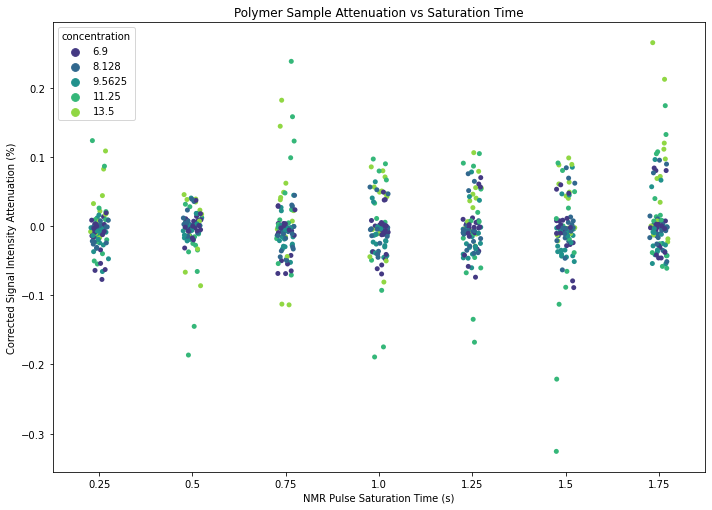

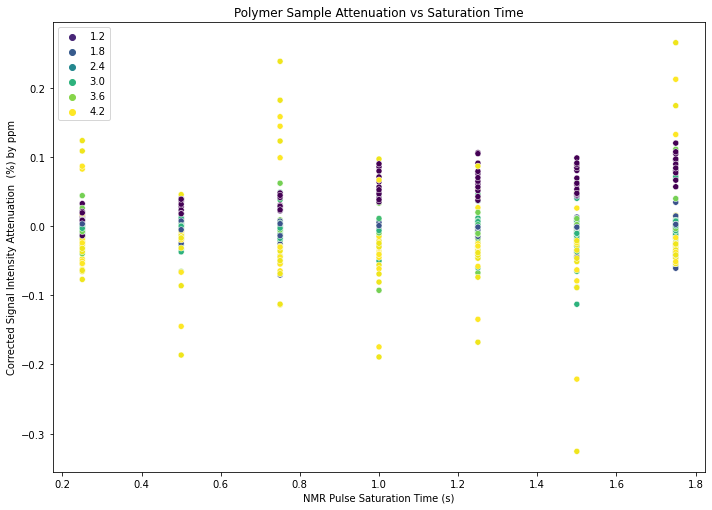

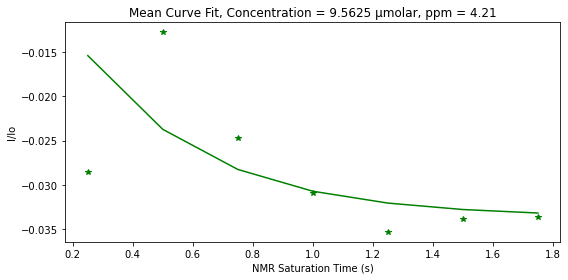

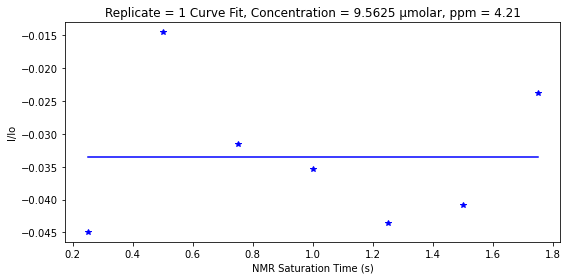

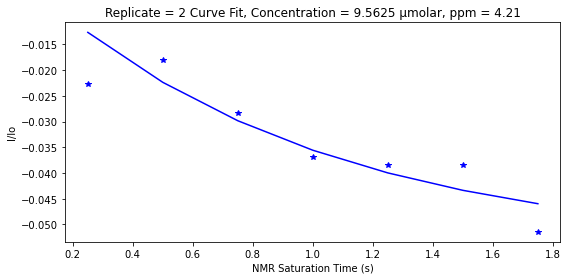

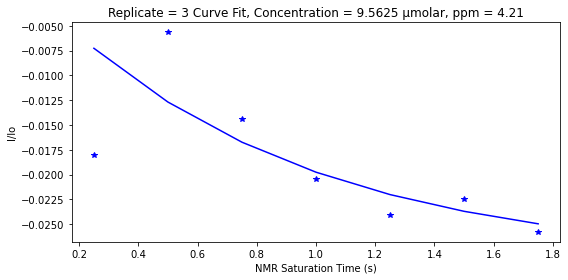

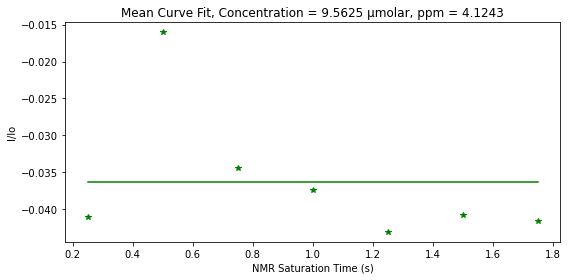

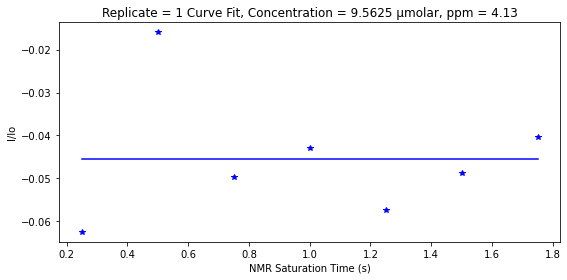

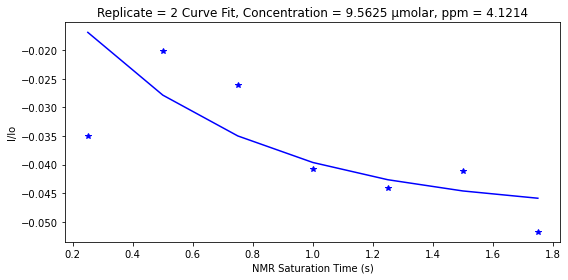

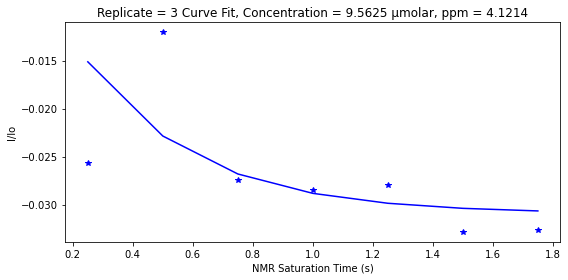

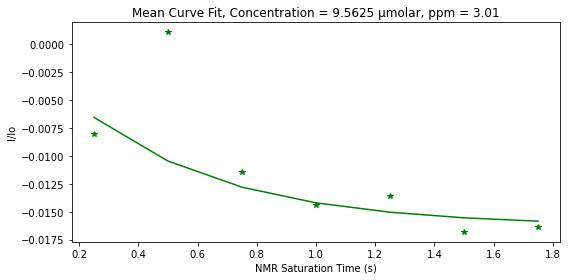

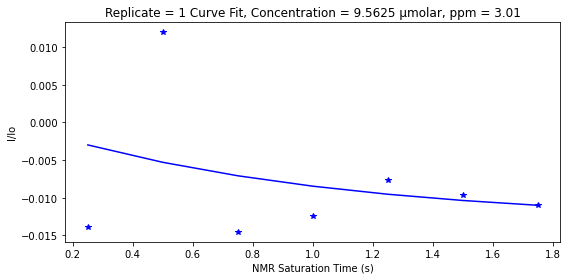

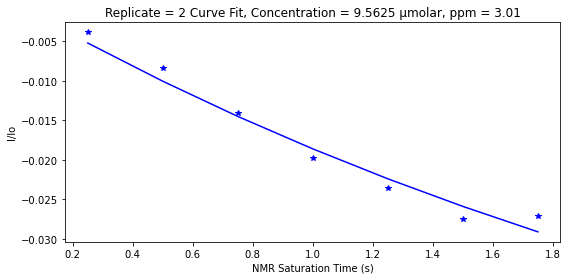

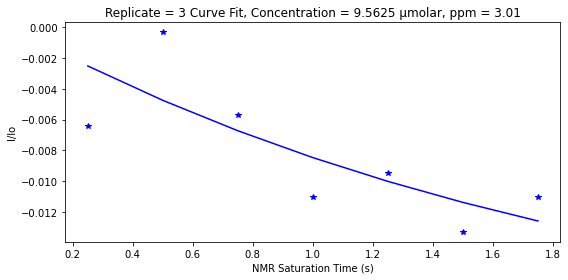

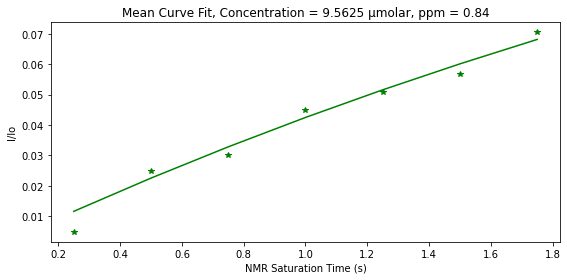

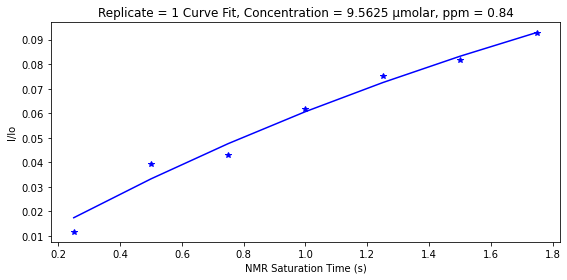

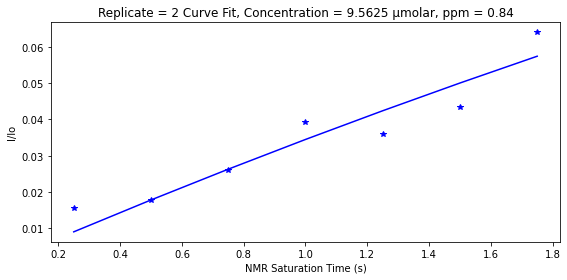

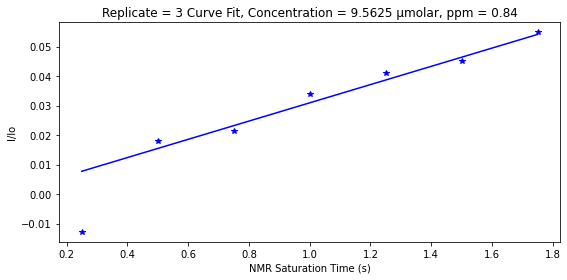

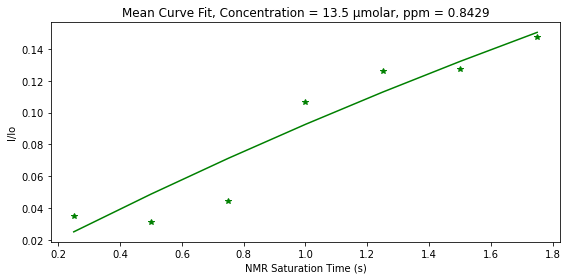

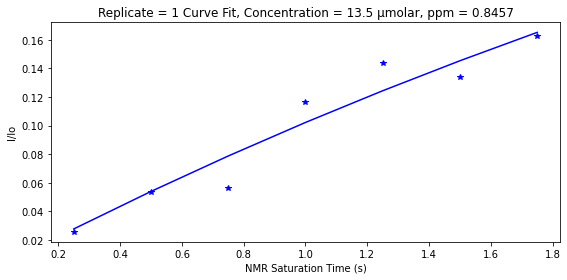

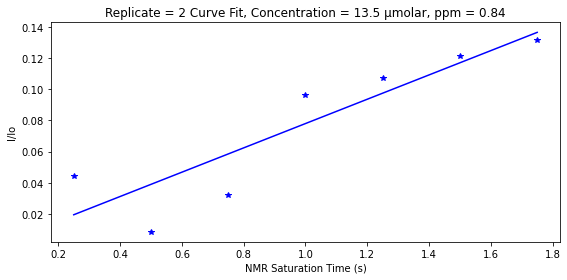

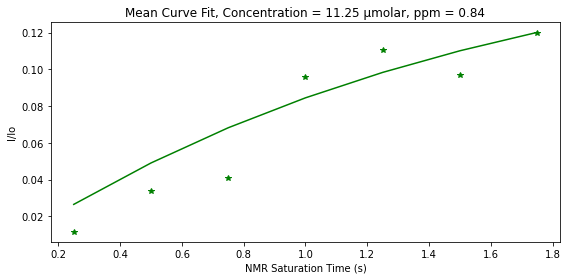

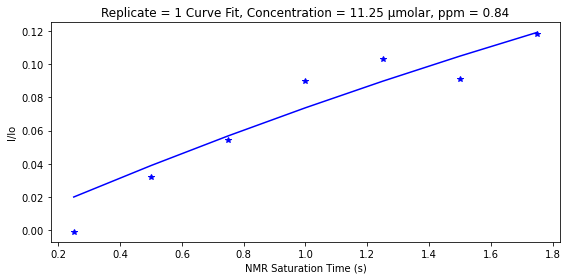

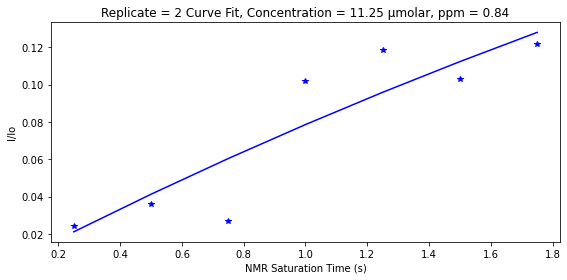

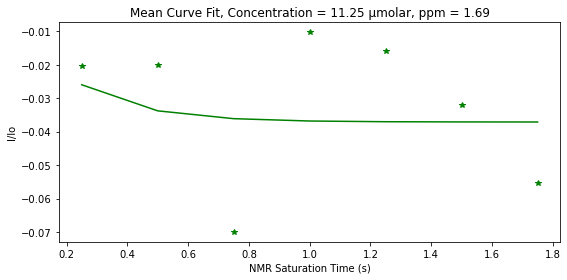

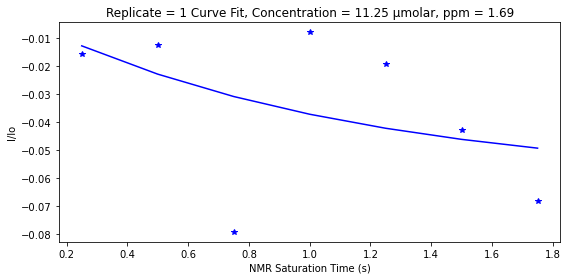

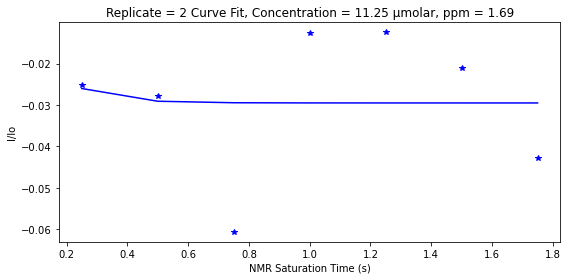

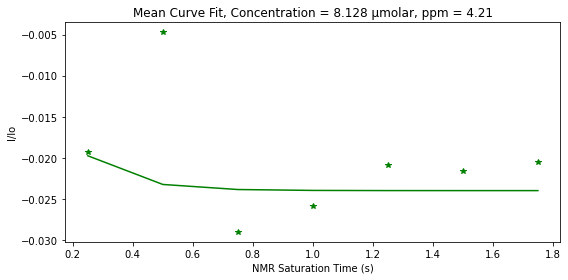

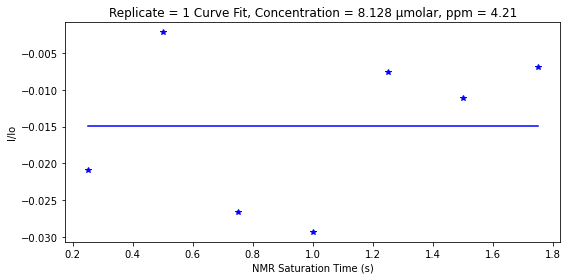

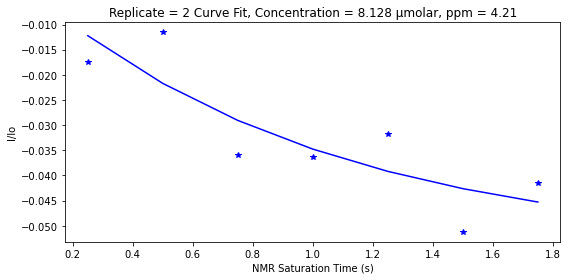

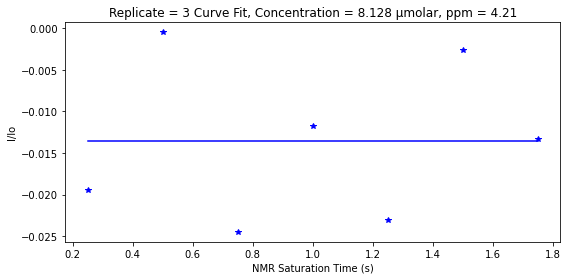

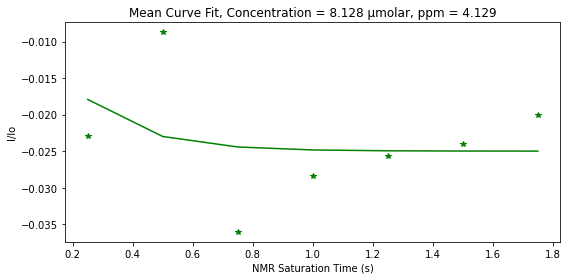

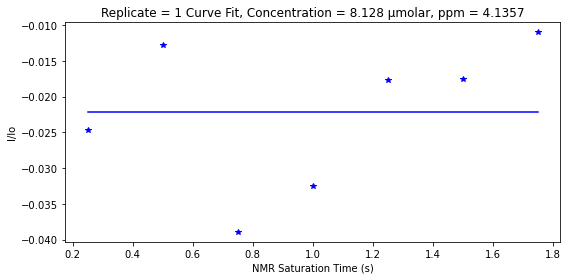

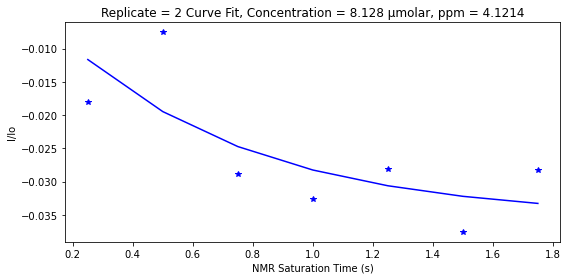

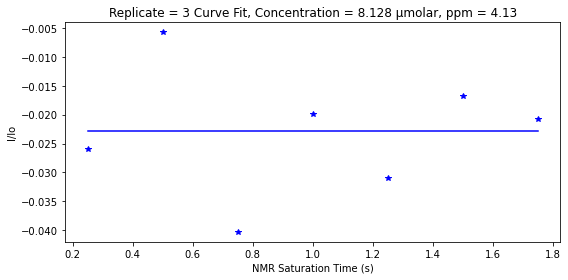

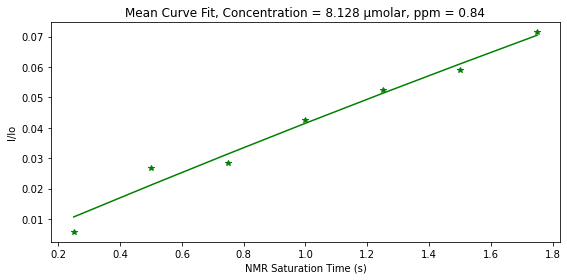

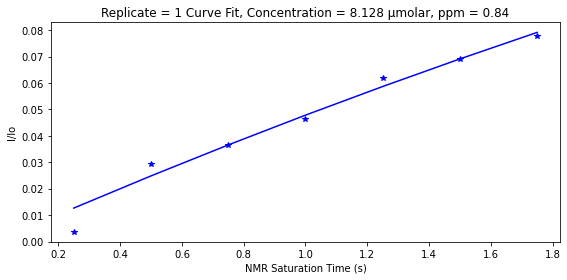

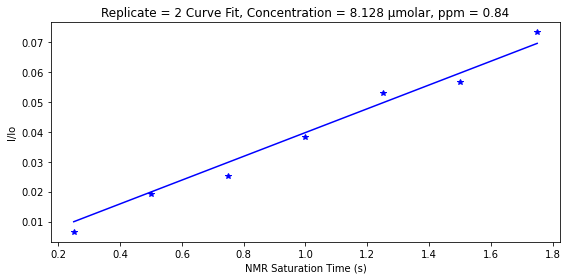

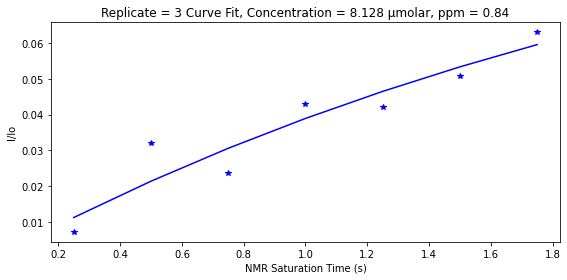

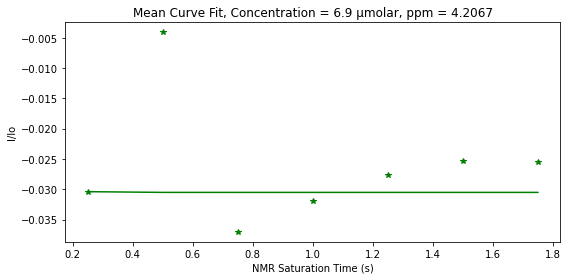

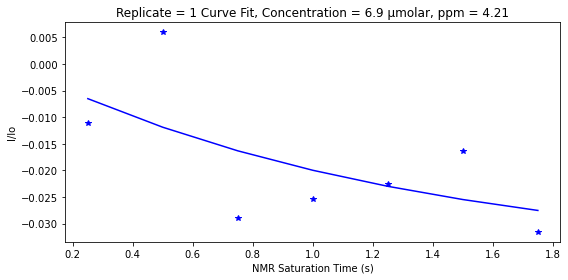

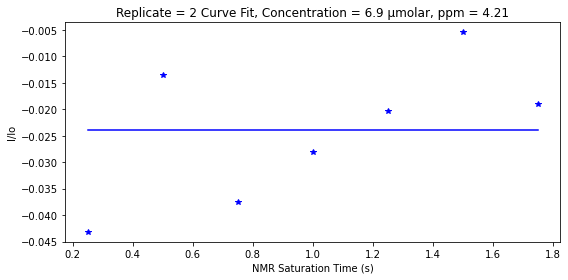

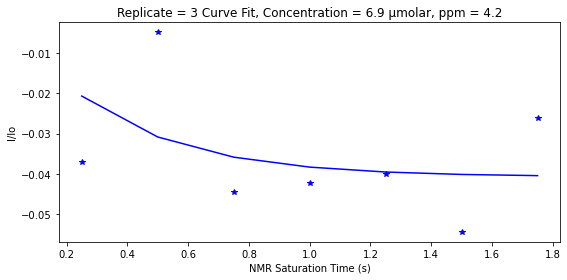

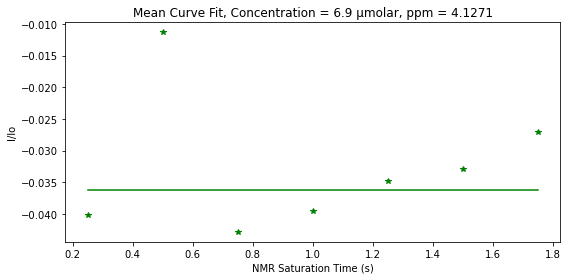

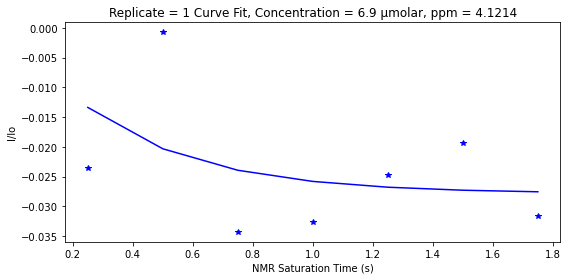

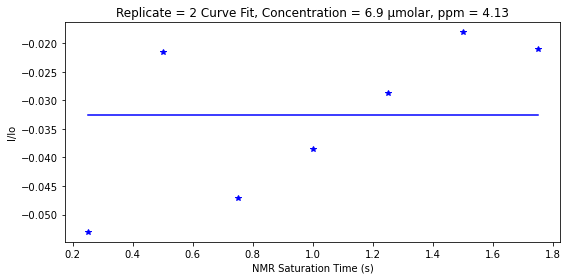

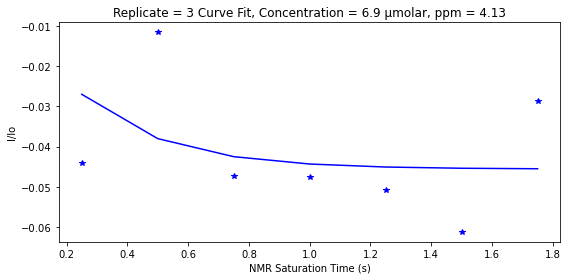

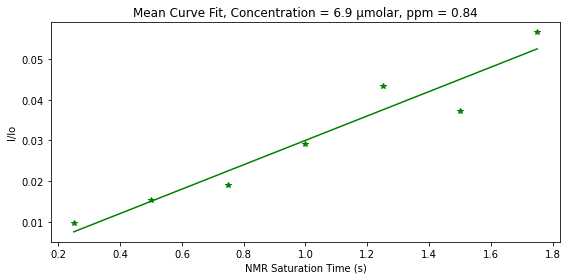

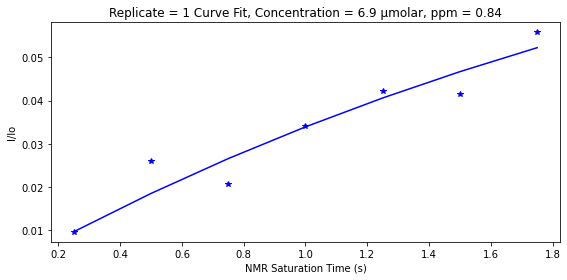

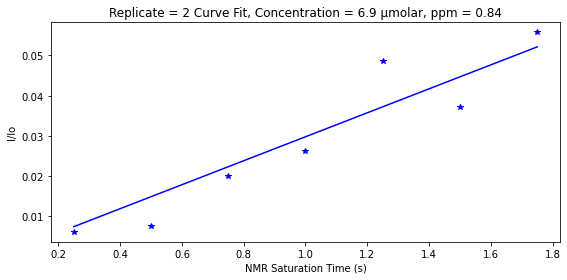

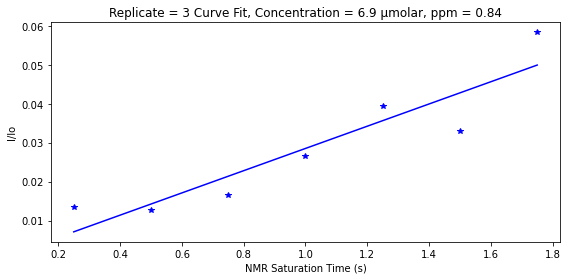

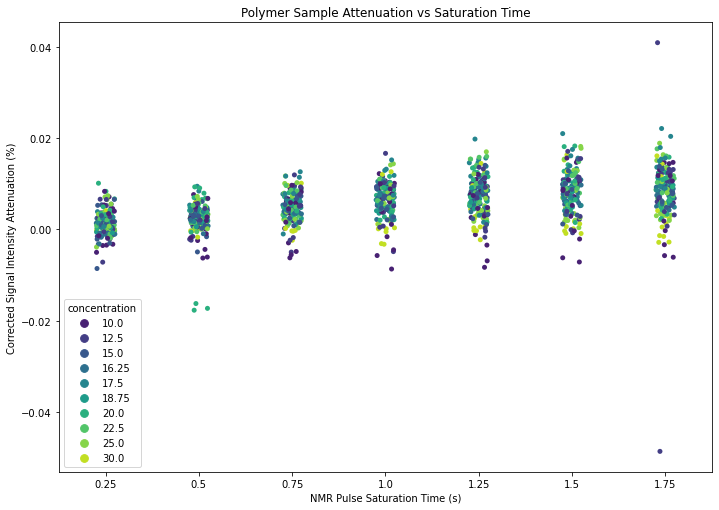

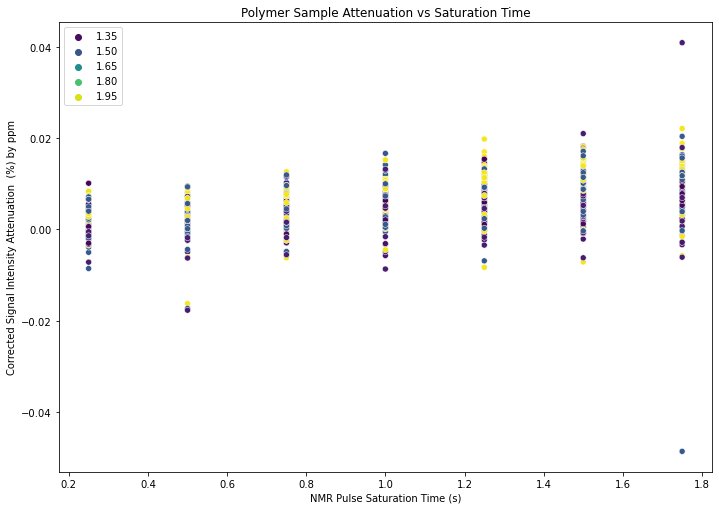

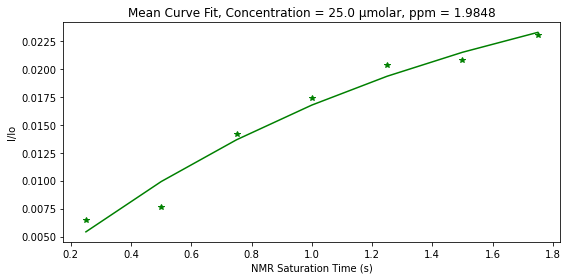

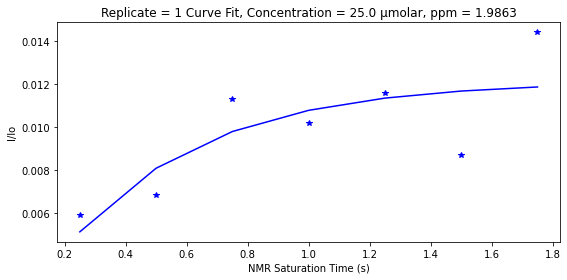

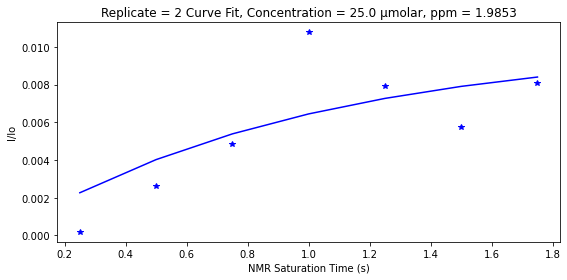

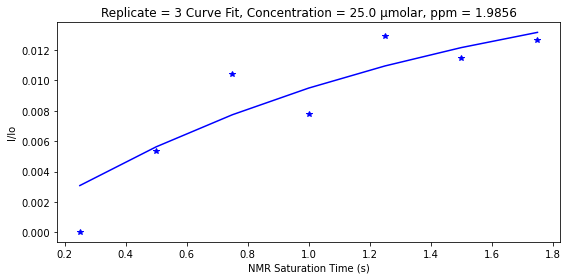

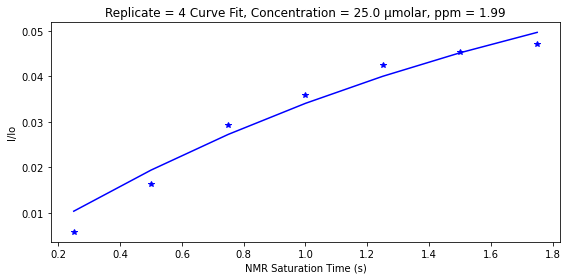

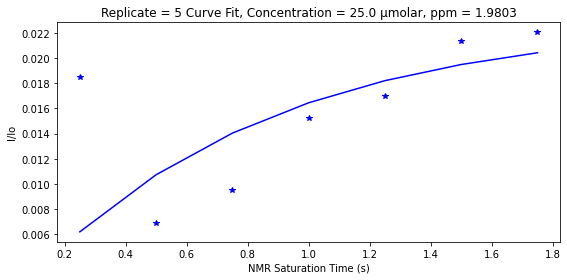

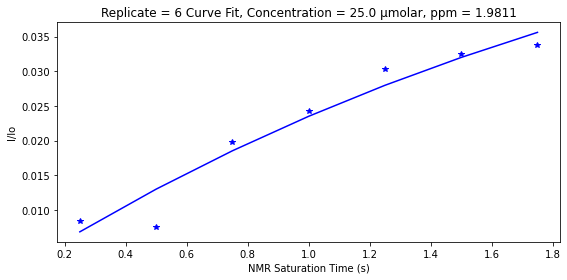

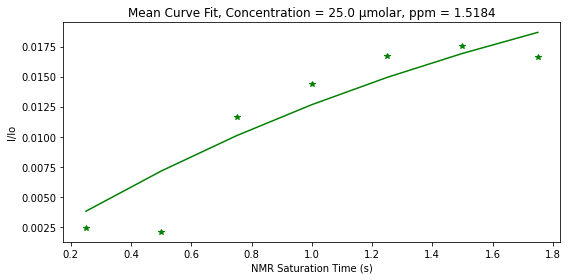

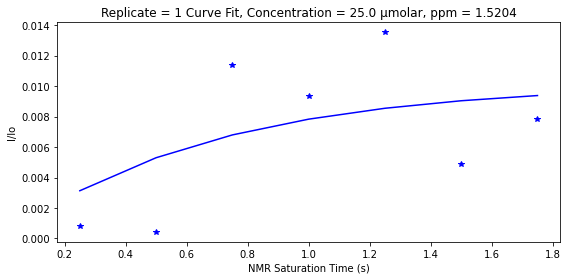

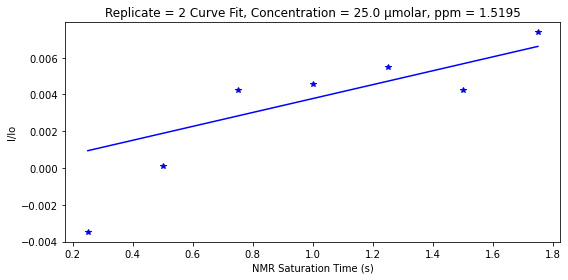

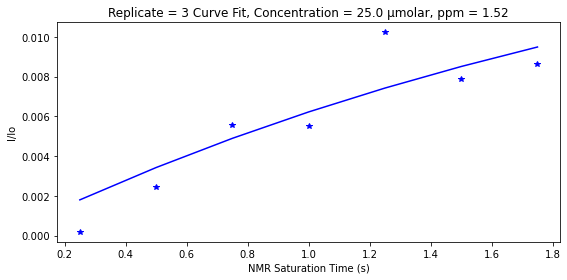

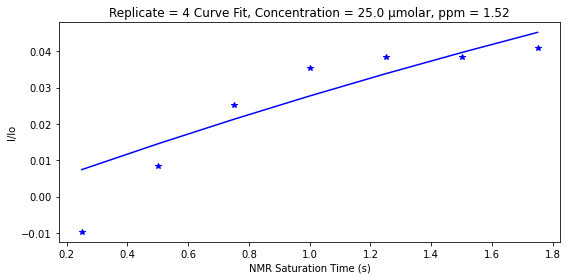

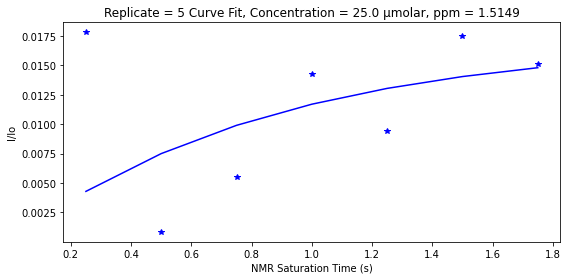

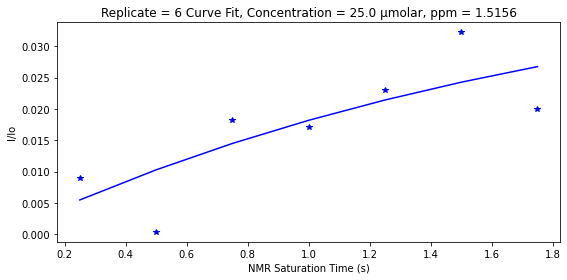

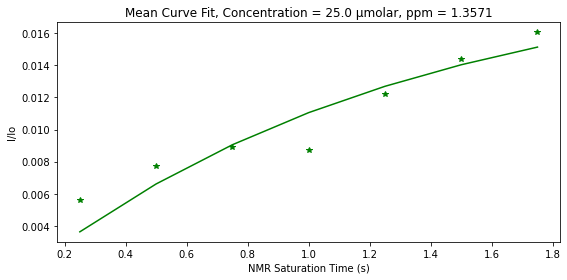

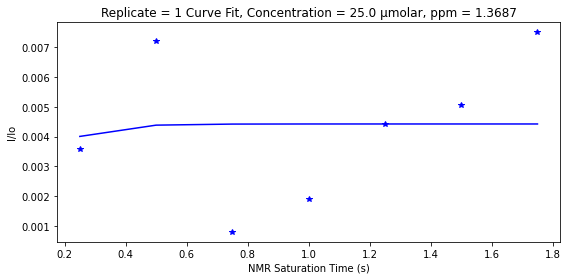

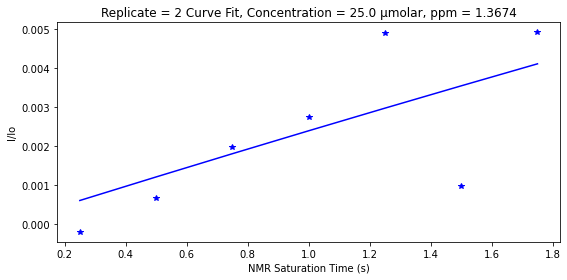

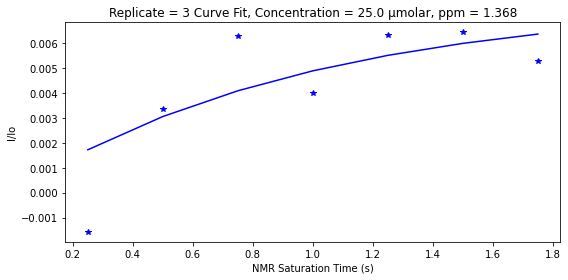

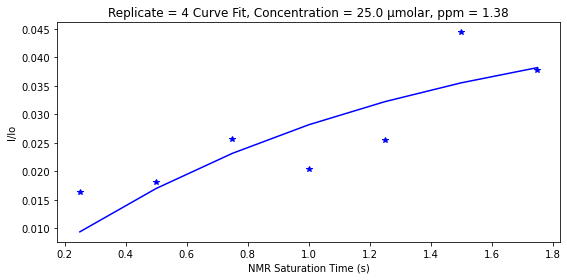

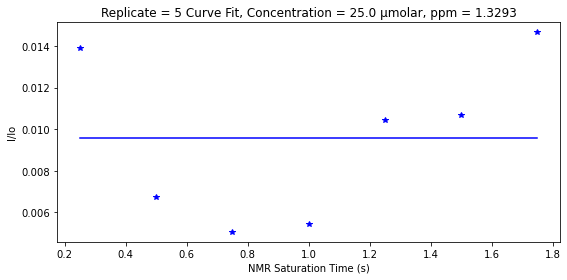

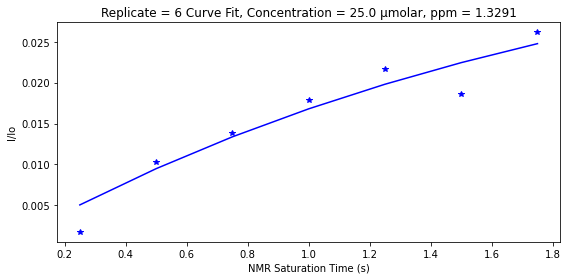

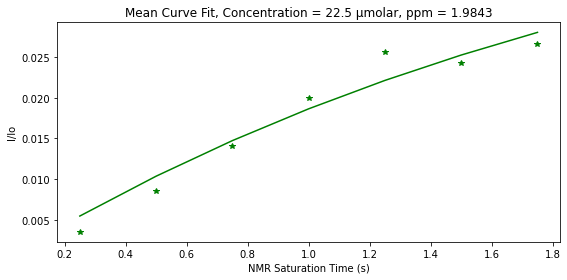

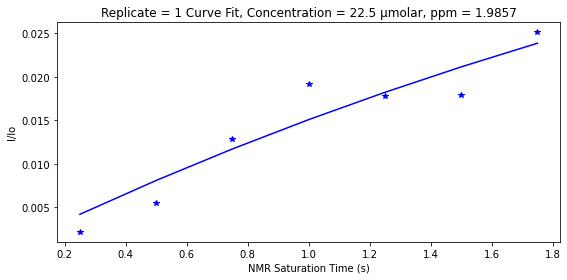

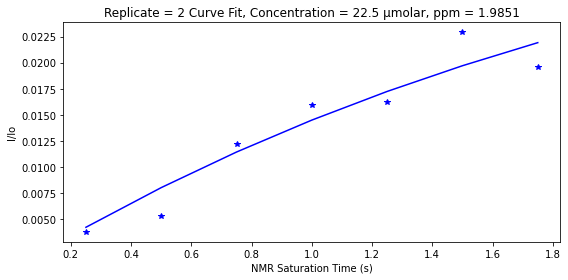

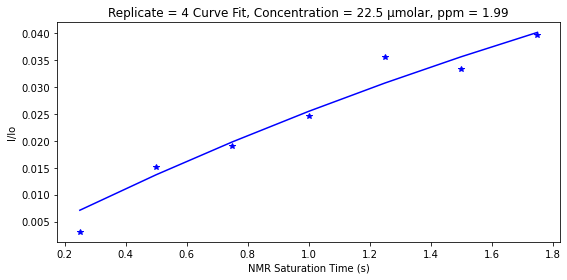

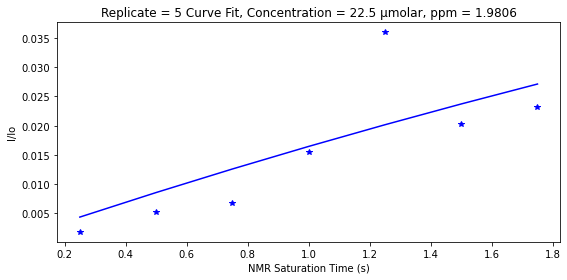

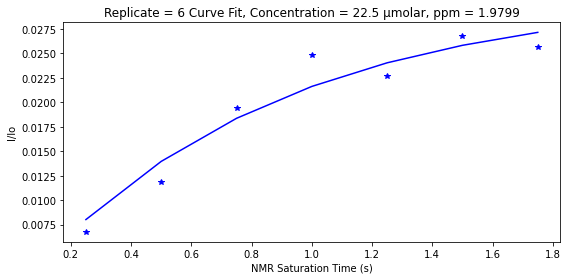

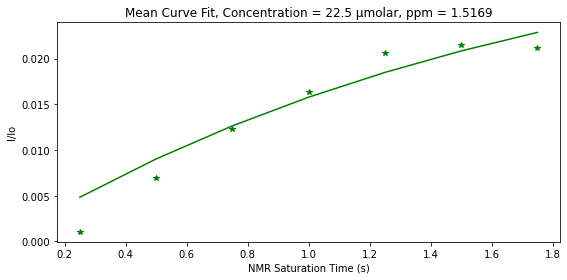

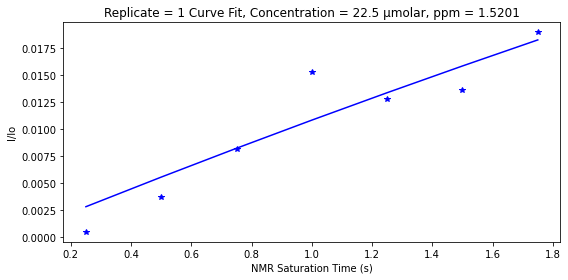

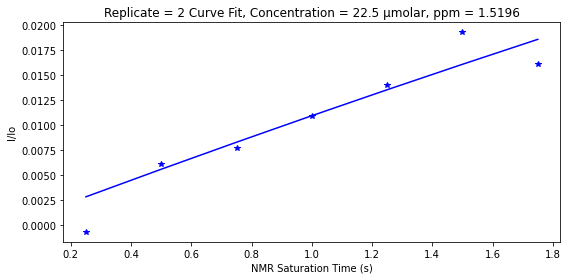

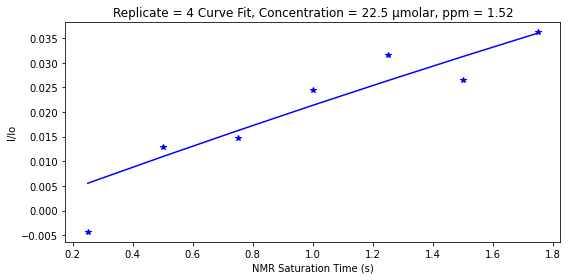

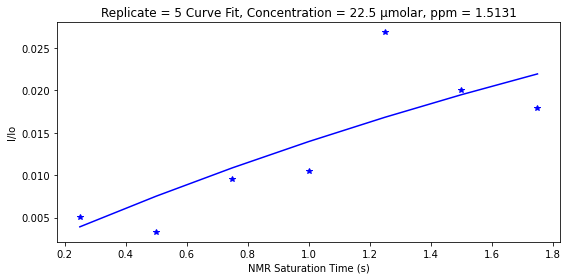

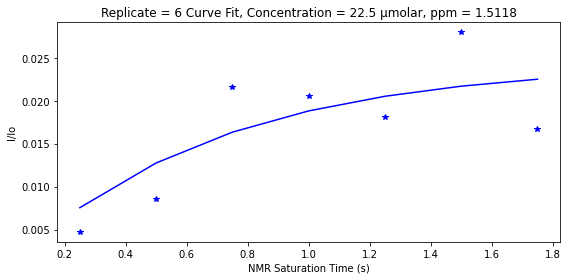

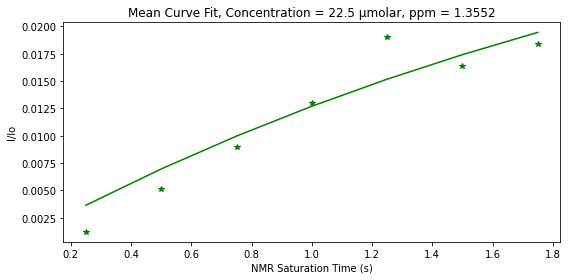

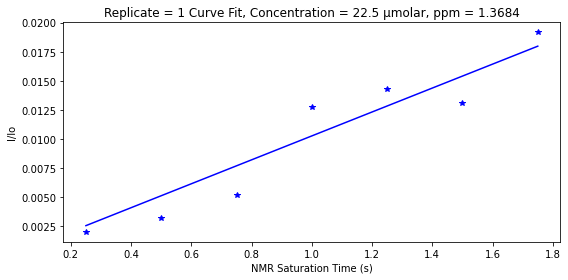

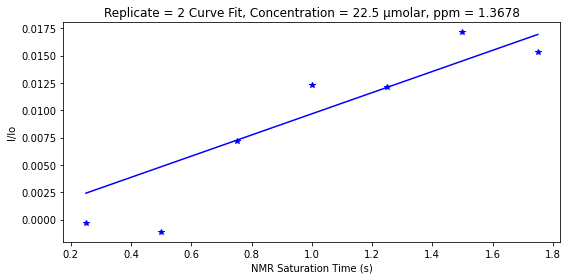

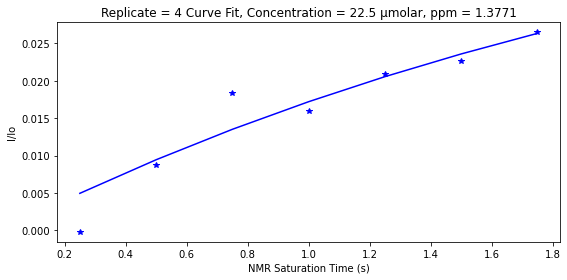

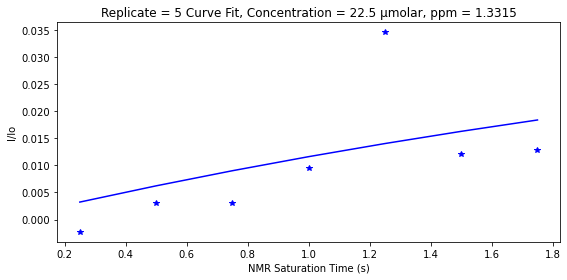

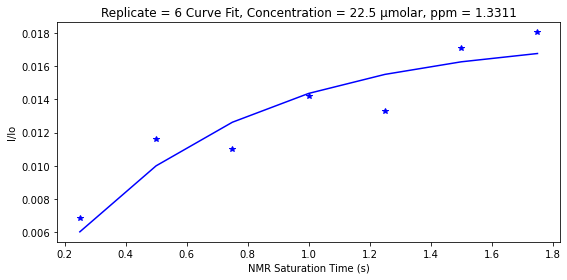

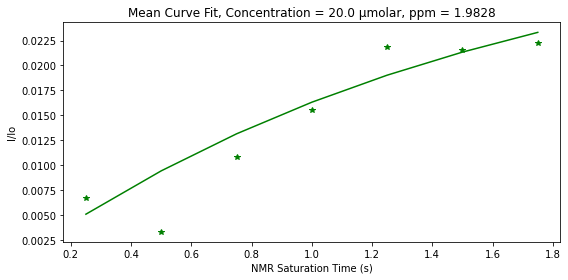

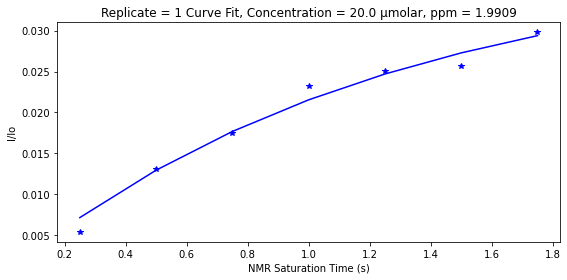

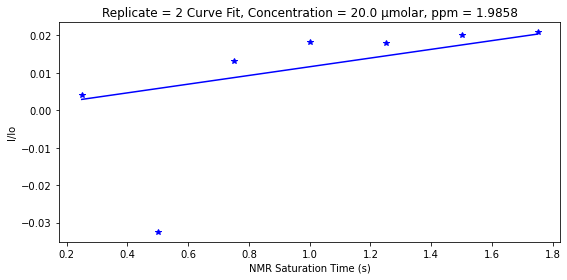

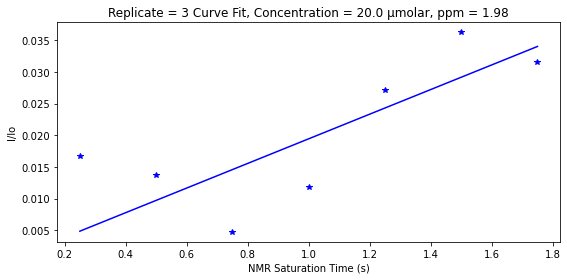

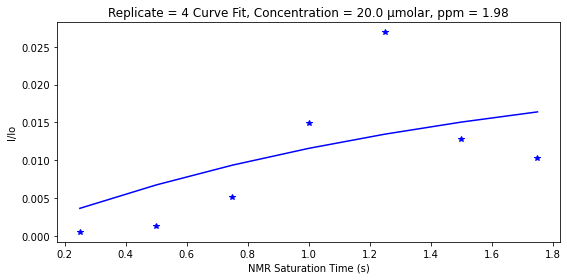

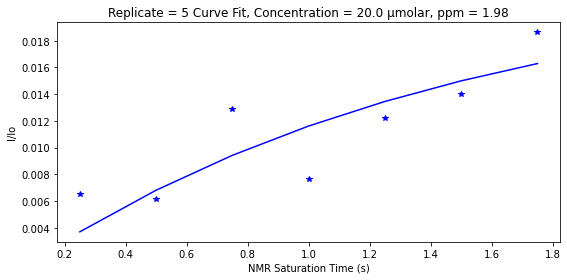

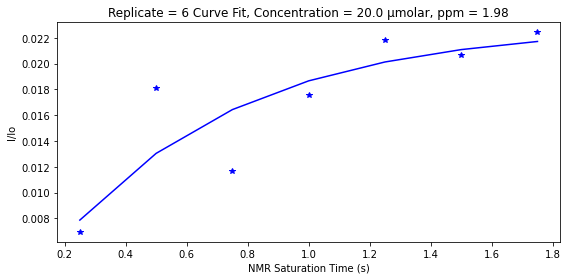

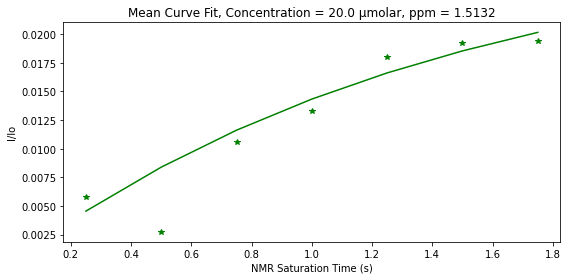

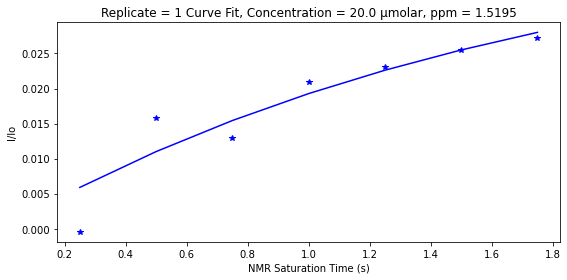

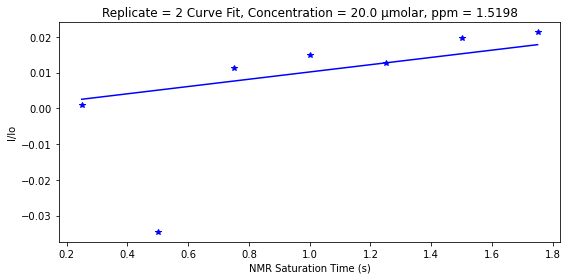

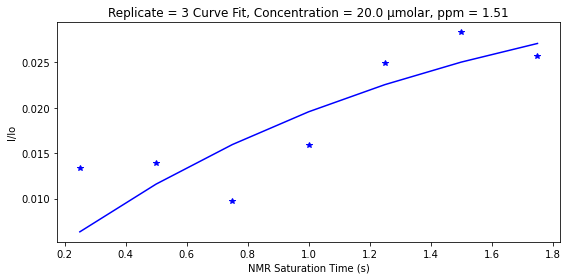

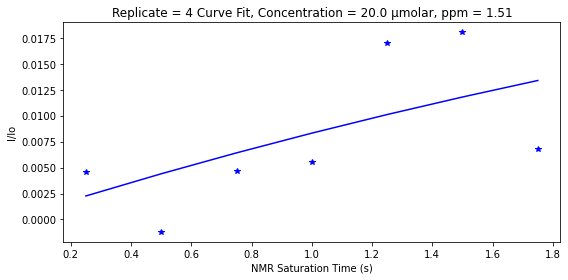

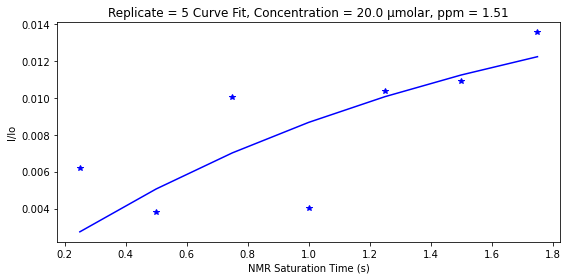

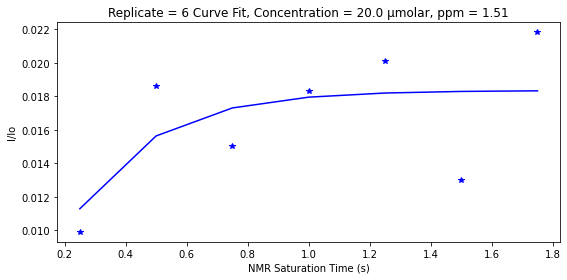

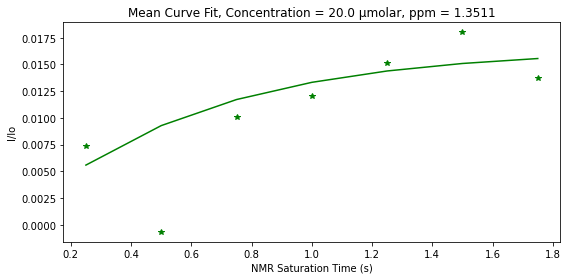

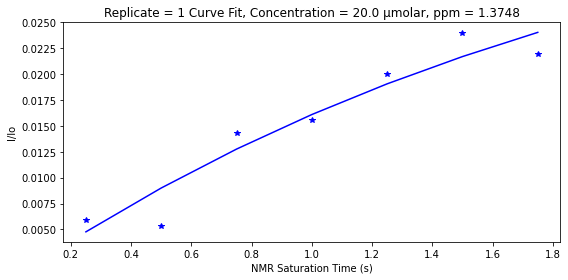

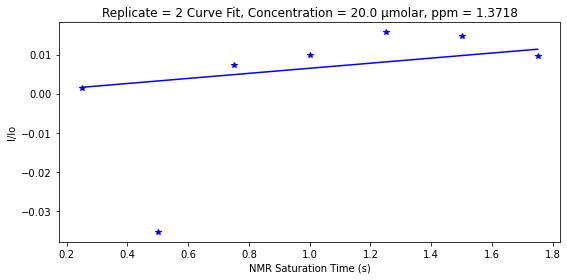

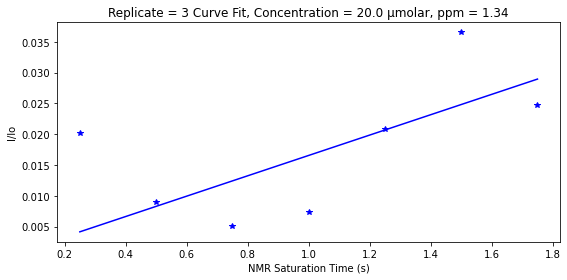

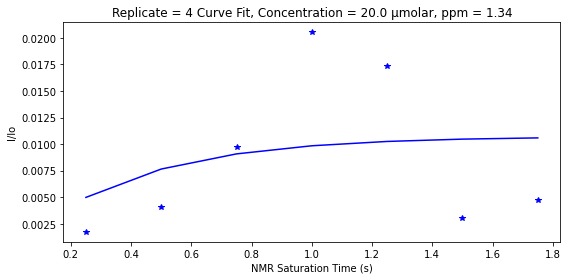

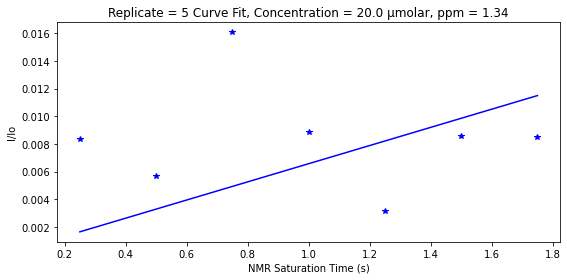

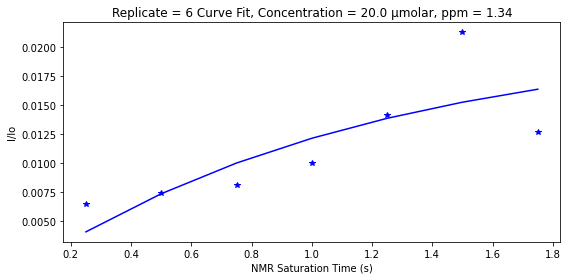

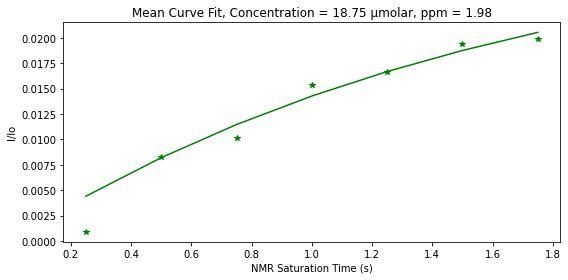

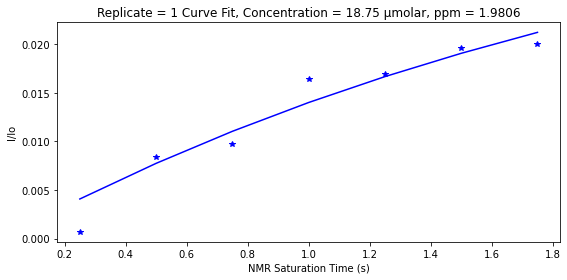

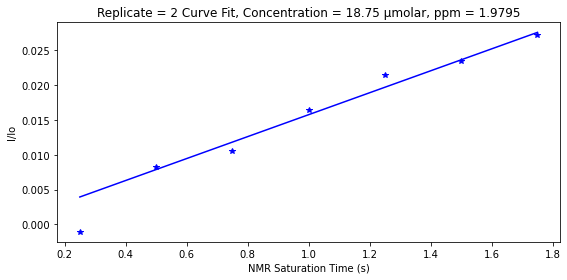

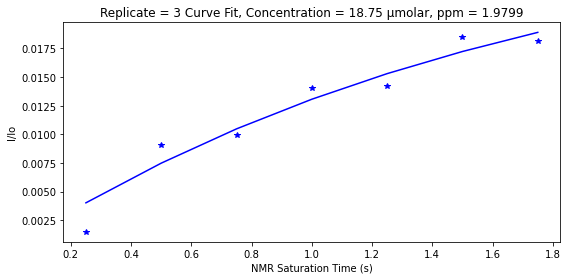

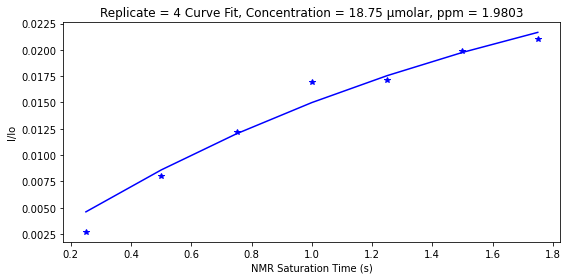

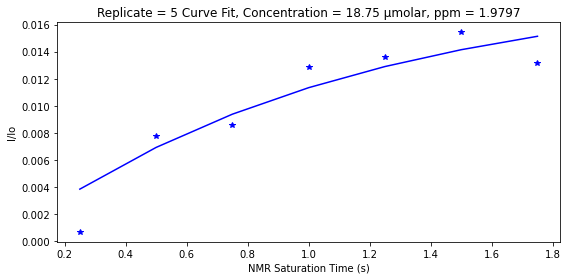

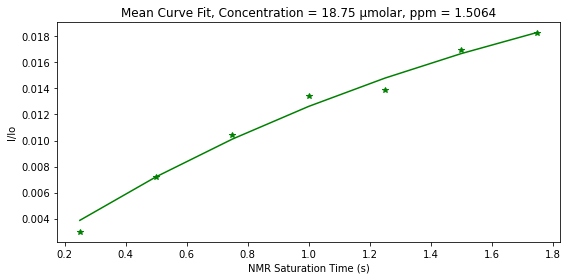

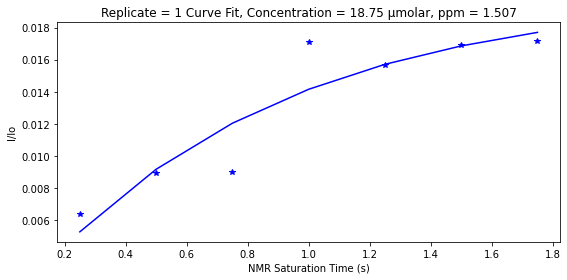

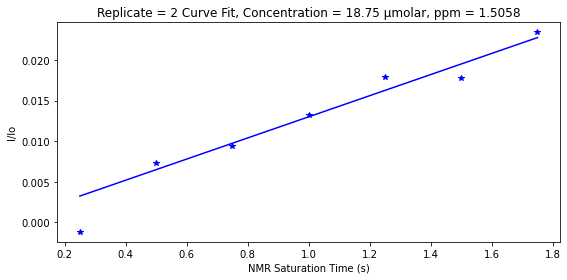

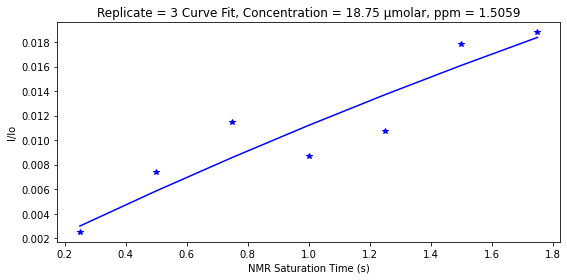

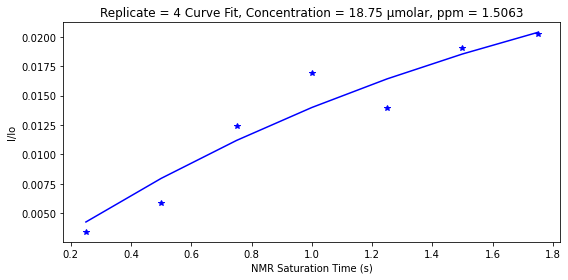

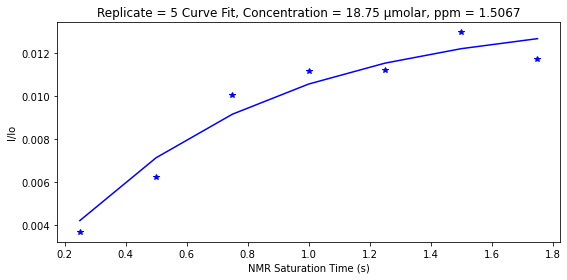

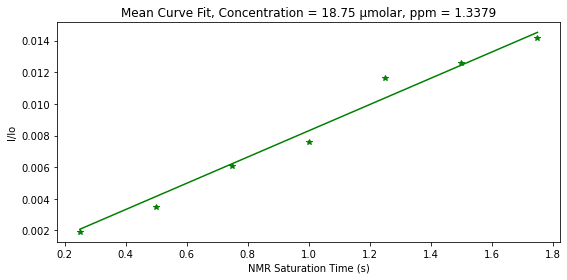

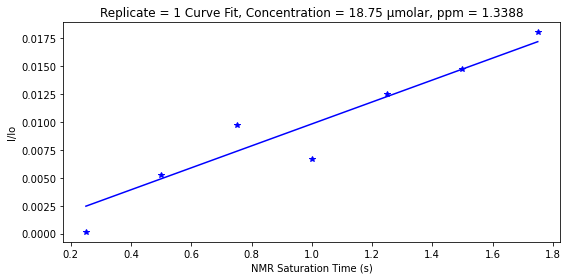

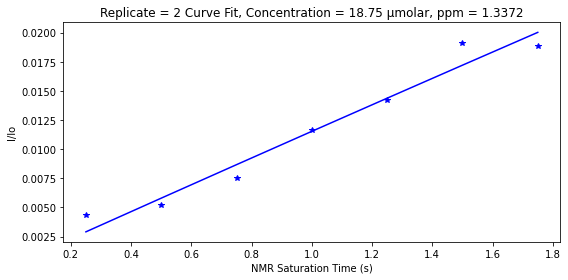

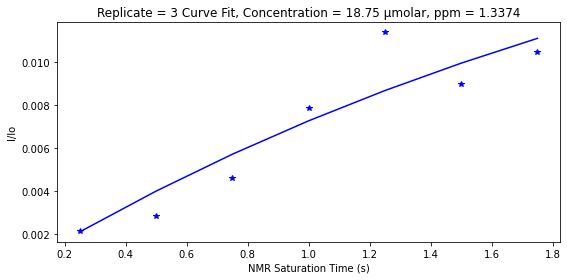

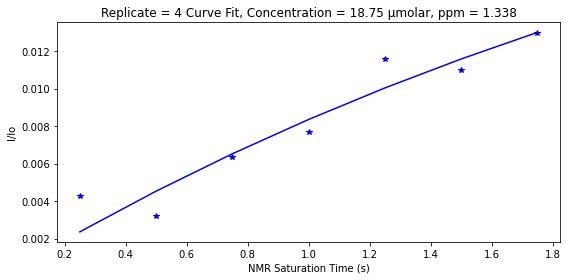

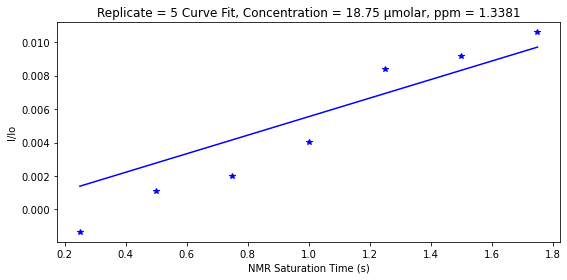

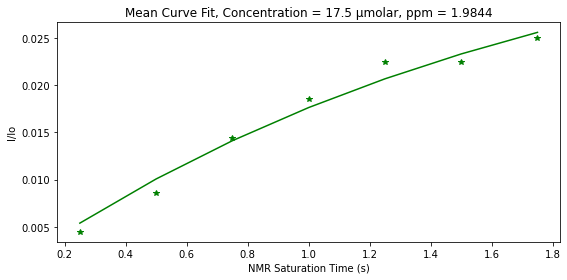

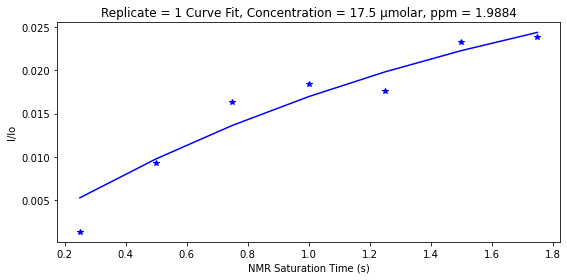

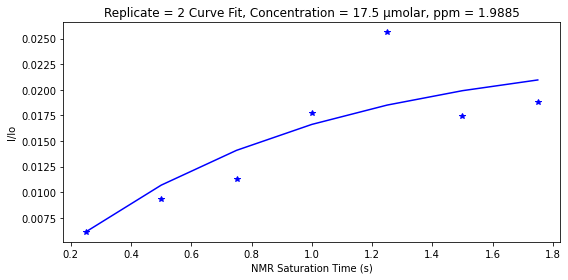

In [ ]:
# LOOP THROUGH EVERY CLEAN DATAFRAME IN THE LIST GENERATED ABOVE ----------------------------------

for i in range(len(clean_book_tuple_list)):
    
    # BEGINNING PART 1 -------- Reading in Data and Visualizing the Results ------------------------ 
    
    #define current dataframe to be analyzed and its title from the tuple output of the data cleaning code
    current_df = clean_book_tuple_list[i][1]
    current_df_title = clean_book_tuple_list[i][0]

    print("Beginning data analysis for {}...".format(current_df_title))

    # DEFINE GLOBAL CUSTOM OUTPUT DIRECTORIES FOR THIS DATAFRAME ------------------------------------------

    # Define a global custom output directory for the current df in the list
    output_directory = "output_from_{}".format(current_df_title)

    # make global directory if there isn't already one for overall output for current df
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    # Define a global output exploratory directory for the exploratory plots 
    output_directory_exploratory = "{}/exploratory_plots_from_{}".format(output_directory, current_df_title)

    # make directory if there isn't already one for exploratory output 
    if not os.path.exists(output_directory_exploratory):
        os.makedirs(output_directory_exploratory)

    # Define a global output directory for the curve fit plots for the current df title
    output_directory2 = "{}/curve_fit_plots_from_{}".format(output_directory, current_df_title)

    # make this directory if there isn't already one for the curve_fit_plots
    if not os.path.exists(output_directory2):
        os.makedirs(output_directory2)  

    # Define a global output directory for the final data tables after curve fitting and stats
    output_directory3 = "{}/data_tables_from_{}".format(output_directory, current_df_title)

    # make this directory if there isn't already one for the data tables
    if not os.path.exists(output_directory3):
        os.makedirs(output_directory3)    

    # CALCULATE ATTENUATION & CORR ATTENUATION -----------------------------------

    current_df_attenuation = add_attenuation_and_corr_attenuation_to_dataframe(current_df)

    # PERFORM EXPLORATORY DATA VISUALIZATION -----------------------------------

    print("Visualizing data for {} and saving to a custom exploratory plots output folder...".format(current_df_title))
    generate_concentration_plot(current_df_attenuation)
    generate_ppm_plot(current_df_attenuation)

    # This completes Part 1 - Data Preprocessing and Visualizing the Results!

    # BEGINNING PART 2 -------- Modelling the Data ---------------------------------------

    # STEP 1 OF 5 - Prepare and generate mean dataframe of current data for stats with degrees of freedom and sample size included -----
    current_df_mean = prep_mean_data_for_stats(current_df_attenuation)
    current_df_replicates = prep_replicate_data_for_stats(current_df_attenuation)

    # STEP 2 OF 5 - Perform t test for statistical significance -------------------------
    current_df_mean = get_t_test_results(current_df_mean)

    # STEP 3 OF 5 - Compute amplification factor -----------------------------------------
    current_df_mean, current_df_replicates = compute_amplification_factor(current_df_mean, current_df_replicates, 10)

    # STEP 4 OF 5 - Drop proton peaks from further analysis that fail our acceptance criteria -----------------------------------------
    current_df_mean, current_df_replicates = drop_bad_peaks(current_df_mean, current_df_replicates)

    # STEP 5 OF 5 - Perform curve fitting, generate plots, and export results to file  -----------------------------------------
    current_df_mean, current_df_replicates = execute_curvefit(current_df_mean, current_df_replicates)
    print("All activities are now completed for: {}".format(current_df_title))

print("Hooray! All books in the input file have been processed.")

In [ ]:
# The below code below can be uncommented for easily "sanity checking" the data. -----------

# It's easier to use this code than the Excel files for quick checks and graph matching imo!
# To use, edit the values in the idx statement[conc, sat_time, proton_peak_index], and the col labels at the end ['SSE_bar'] (this can be removed if you want to see the whole subset for a graph).

# For Mean DataFrame
# checking = current_df_mean.loc[idx[12.5, :, 2]]['SSE_bar']
# print(checking)

# For Replicate DataFrame
# checking_rep = current_df_replicates.loc[(current_df_replicates['proton_peak_index'] == 2) & (current_df_replicates['concentration'] == 12.5) & (current_df_replicates['replicate'] == 5)]['SSE']
# print(checking_rep)